# TO-DO

* adding val for OZ variant

# Initialization

## Imports

In [1]:
from dataclasses import dataclass

import pandas as pd
import numpy as np
import random

# import plotly.io as pio
# pio.renderers.default = "vscode"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from collections import defaultdict
from contextlib import contextmanager

import pickle
import json
import os
from pathlib import Path
from os.path import join as pjoin
from tqdm.auto import tqdm
from copy import deepcopy
import shutil
from time import sleep

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

import torch
import torch.nn as nn
import torch.optim as optim

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Checkpoint
from skorch.dataset import ValidSplit

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 14

## Args

In [3]:
@dataclass
class VisProd:
    epochs: int = 6
    lambda_color: float = 1
    lambda_shape: float = 1
    lambda_MI: float = 0

    lr: float = 5e-2
    optimizer: str = 'Adam'
    # optimizer: str = 'SGD'

    calibrate: bool = False

@dataclass
class Args:
    outputs_dir: str = 'analysis'

    dataset_name: str = 'ao_clevr'
    data_dir: str = '' # empty = f'data/{args.dataset_name}'
    dataset_variant: str = 'VT'
    # dataset_variant: str = 'OZ'
    
    seen_seed:int = 0
    num_split:int = 5000

    # val_unseen_mode: str = 'leave' # leave Yuval's val as is (with 5 images for unseen combinations)
    val_unseen_mode: str = 'complete' # add images to val unseen combinations to reach the mean val size in seen combinations 
    # val_unseen_mode: str = 'drop' # drop any val images from unseen combinations 


    # only for OZ splits
    train_size: int = int(80e3)
    train_unseen_ovr_seen: float = 0
    test_size: int = int(8e3)

    # for training
    init_seed: int = 0 # for torch seeding
    skorch_val_ratio: float = 0.3 # split is done inside skorch training; NOT related to 'val' dataset used for calibration, hypertuning
    batch_size: int = 1024 # also for sampling multi-shifts (multi-shifted train) for MLLS training
    pin_memory: bool = True
    workers: int = 0

    VP: VisProd = VisProd()

args = Args()

In [4]:
if args.data_dir == '':
    args.data_dir = f'data/{args.dataset_name}'
    
num_split_str = str(args.num_split)
unseen_ovr_tot = int(num_split_str[:2])/100
data_seed = int(num_split_str[3:])

## Definitions

In [5]:
def torch_setup(deterministic: bool = True):
    # Setting up torch, seeding (https://pytorch.org/docs/stable/notes/randomness.html)
    # ///////////// Making pytorch deterministic (reproducible)  ////////////////////////////////////////////////////
    if deterministic:
        # read WELL: https://pytorch.org/docs/stable/notes/randomness.html
        # the order of execution is important!

        # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
        #     os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8" # may limit overall performance
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # will increase library footprint in GPU memory by approximately 24MiB
        torch.backends.cudnn.benchmark = False
        print(f"executed: torch.backends.cudnn.benchmark = False")

        torch_set_deterministic = False
        # try:
        #     torch.set_deterministic(True) # beta in torch==1.7
        #     print(f"executed torch.set_deterministic(True)")
        #     torch_set_deterministic = True
        # except Exception as ex:
        #     logger.warning(f"torch.set_deterministic(True) failed: {ex}")
        try:
            torch.use_deterministic_algorithms(True)  # beta in torch==1.8
            print(f"executed: torch.use_deterministic_algorithms(True)")
            torch_set_deterministic = True
        except Exception as ex:
            print(f"torch.use_deterministic_algorithms(True) failed: {ex}")

        if not torch_set_deterministic:  # already contained in torch.use_deterministic_algorithms(True)
            torch.backends.cudnn.deterministic = True
            print(f"executed: torch.backends.cudnn.deterministic = True")

        print(f"torch and cuda will be deterministic (after seeding)")
    else:
        torch.backends.cudnn.benchmark = True
        print(f"executed: torch.backends.cudnn.benchmark = True (torch is not determinisitc!)")
        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print('torch is using %s (%s)'%(device, torch.cuda.get_device_name(device=0)))
    else:
        print('torch is using %s'%(device))
    return device

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed + 1000)
    torch.manual_seed(seed + 2000)
    torch.cuda.manual_seed(seed + 3000)
    print(f"completed: seeding with seed={seed} in steps of 1000 for random,np,torch,cuda")


def basic_EM(Y, Y_probs, prior_source, EM_iterations: int = 100):
    # init
    EM_results = pd.DataFrame(index=range(EM_iterations))
    EM_results.index.name = 'iteration'
    shift_probs_0 = Y_probs
    shift_probs = shift_probs_0
    prior_shift_pred = prior_source

    # eval
    shift_preds = shift_probs.argmax(axis=1)
    positives = shift_preds==Y
    # EM_results.loc[0, [f'accuracy ({label})' for label in range(args.n_labels)]] = positives.mean(axis=0)
    EM_results.loc[0, 'accuracy'] = positives.mean()
    Y_true_pos_probs = np.take_along_axis(shift_probs, Y.reshape(-1,1), axis=1)
    EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

    # EM
    for i_EM in tqdm(range(1, 1+EM_iterations)):        
        # E-step
        shift_probs = shift_probs_0 * prior_shift_pred / prior_source
        shift_probs = (shift_probs.T / shift_probs.sum(axis=1)).T
        
        shift_preds = shift_probs.argmax(axis=1)
        
        # eval
        positives = shift_preds==Y
        EM_results.loc[i_EM, 'accuracy'] = positives.mean()
        Y_true_pos_probs = np.take_along_axis(shift_probs, Y.reshape(-1,1), axis=1)
        EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

        # M-step
        prior_shift_pred = shift_probs.mean(axis=0)
    assert (~np.isfinite(shift_probs)).sum() == 0
    return EM_results, shift_probs


def EM(Y:dict, Y_probs:dict, EM_iterations: int = 100, prior_source_phase: str = 'est. soft train',
        init_prior: str = 'source prior', n_combs: int = None,
        soft_prior: bool = True, over_update_probs: bool = False):
    """
    Y and Y_probs: dictionaries with 'train' and 'test' keys, EM adaptation is done on 'test'
    soft_prior:
        (for proper EM) True: SOFT prior_shift_pred = shift_probs.mean(axis=0)
        (for improper EM) False: HARD prior_shift_pred (calculated from hist)
    over_update_probs:
        (for proper EM) False: shift_probs = shift_probs_0 * prior_shift_pred / prior_train
        (for improper EM) True: shift_probs = shift_probs * prior_shift_pred / prior_train
    """
    
    if (not soft_prior) or over_update_probs or (prior_source_phase != 'est. soft train'):
        confirm_ui = input("confirm performing an IMPROPER EM for debugging, " \
            "(for a proper EM, set: soft_prior = True, over_update_probs = False, "\
            "prior_source_phase = 'est. soft train'): y/[n] ")
        if confirm_ui != 'y':
            raise RuntimeError("terminated by user")

    if 'est. soft' in prior_source_phase:
        Y_probs_source = Y_probs['test' if 'test' in prior_source_phase else 'train']
        prior_source = Y_probs_source.mean(axis=0)
    elif 'true' in prior_source_phase:
        Y_source = Y['test' if 'test' in prior_source_phase else 'train']
        hist = np.bincount(Y_source, minlength=n_combs)
        prior_source = hist / hist.sum()
    elif prior_source_phase == 'uniform':
        prior_source = 1/n_combs * np.ones(n_combs)
    else:
        raise NotImplementedError
    
    print(f"source prior ('{prior_source_phase}'):")
    display(prior_source)

    # init
    EM_results = pd.DataFrame(index=range(EM_iterations))
    EM_results.index.name = 'iteration'
    shift_labels = Y['test']
    shift_probs_0 = Y_probs['test']
    shift_probs = shift_probs_0

    if init_prior == 'source prior':
        prior_shift_pred = prior_source
    elif init_prior == 'uniform':
        prior_shift_pred = 1/n_combs * np.ones(n_combs)
    else:
        raise NotImplementedError

    # eval
    shift_preds = shift_probs.argmax(axis=1)
    positives = shift_preds==shift_labels
    # EM_results.loc[0, [f'accuracy ({label})' for label in range(args.n_labels)]] = positives.mean(axis=0)
    EM_results.loc[0, 'accuracy'] = positives.mean()
    # likelihood
    Y_true_pos_probs = np.take_along_axis(shift_probs, Y['test'].reshape(-1,1), axis=1)
    EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

    # EM
    for i_EM in tqdm(range(1, 1+EM_iterations)):        
        # E-step
        if over_update_probs:
            shift_probs = shift_probs * prior_shift_pred / prior_source
        else:
            shift_probs = shift_probs_0 * prior_shift_pred / prior_source
        shift_probs = (shift_probs.T / shift_probs.sum(axis=1)).T
        
        shift_preds = shift_probs.argmax(axis=1)
        
        # eval
        positives = shift_preds==shift_labels
        EM_results.loc[i_EM, 'accuracy'] = positives.mean()
        # likelihood
        Y_true_pos_probs = np.take_along_axis(shift_probs, Y['test'].reshape(-1,1), axis=1)
        EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

        # M-step
        if soft_prior:
            prior_shift_pred = shift_probs.mean(axis=0)
        else:
            hist_shift_pred = np.bincount(shift_preds, minlength=args.n_classes_per_label * args.n_labels)
            prior_shift_pred = hist_shift_pred / hist_shift_pred.sum()

    assert (~np.isfinite(shift_probs)).sum() == 0
    return EM_results, shift_probs

## Yuval's defitions

In [6]:
if args.dataset_variant in ['VT', 'UV']:
    from typing import NamedTuple
    from pathlib import Path
    from ATTOP.data.dataset import sample_negative as ATTOP_sample_negative
    from torch.utils import data
    from COSMO_utils import temporary_random_numpy_seed


    def get_and_update_num_calls(func_ptr):
        try:
            get_and_update_num_calls.num_calls_cnt[func_ptr] += 1
        except AttributeError as e:
            if 'num_calls_cnt' in repr(e):
                get_and_update_num_calls.num_calls_cnt = defaultdict(int)
            else:
                raise

        return get_and_update_num_calls.num_calls_cnt[func_ptr]

    def categorical_histogram(data, labels_list, plot=True, frac=True, plt_show=False):
        import matplotlib.pyplot as plt
        s_counts = pd.Series(data).value_counts()
        s_frac = s_counts/s_counts.sum()
        hist_dict = s_counts.to_dict()
        if frac:
            hist_dict = s_frac.to_dict()
        hist = []
        for ix, _ in enumerate(labels_list):
            hist.append(hist_dict.get(ix, 0))

        if plot:
            pd.Series(hist, index=labels_list).plot(kind='bar')
            if frac:
                plt.ylim((0,1))
            if plt_show:
                plt.show()
        else:
            return np.array(hist, dtype='float32')

    class DataItem(NamedTuple):
        """ A NamedTuple for returning a Dataset item """
        feat: torch.Tensor
        pos_attr_id: int
        pos_obj_id: int
        neg_attr_id: int
        neg_obj_id: int
        image_fname: str


    class CompDataFromDict():
        # noinspection PyMissingConstructor
        def __init__(self, dict_data: dict, data_subset: str, data_dir: str):

            # define instance variables to be retrieved from struct_data_dict
            self.split: str = 'TBD'
            self.phase: str = 'TBD'
            self.feat_dim: int = -1
            self.objs: list = []
            self.attrs: list = []
            self.attr2idx: dict = {}
            self.obj2idx: dict = {}
            self.pair2idx: dict = {}
            self.seen_pairs: list = []
            self.all_open_pairs: list = []
            self.closed_unseen_pairs: list = []
            self.unseen_closed_val_pairs: list = []
            self.unseen_closed_test_pairs: list = []
            self.train_data: tuple = tuple()
            self.val_data: tuple = tuple()
            self.test_data: tuple = tuple()

            self.data_dir: str = data_dir

            # retrieve instance variables from struct_data_dict
            vars(self).update(dict_data)
            self.data = dict_data[data_subset]

            self.activations = {}
            features_dict = torch.load(Path(data_dir) / 'features.t7')
            for i, img_filename in enumerate(features_dict['files']):
                self.activations[img_filename] = features_dict['features'][i]

            self.input_shape = (self.feat_dim,)
            self.num_objs = len(self.objs)
            self.num_attrs = len(self.attrs)
            self.num_seen_pairs = len(self.seen_pairs)
            self.shape_obj_attr = (self.num_objs, self.num_attrs)

            self.flattened_seen_pairs_mask = self.get_flattened_pairs_mask(self.seen_pairs)
            self.flattened_closed_unseen_pairs_mask = self.get_flattened_pairs_mask(self.closed_unseen_pairs)
            self.flattened_all_open_pairs_mask = self.get_flattened_pairs_mask(self.all_open_pairs)
            self.seen_pairs_joint_class_ids = np.where(self.flattened_seen_pairs_mask)

            self.y1_freqs, self.y2_freqs, self.pairs_freqs = self._calc_freqs()
            self._just_load_labels = False

            self.train_pairs = self.seen_pairs

        def sample_negative(self, attr, obj):
            return ATTOP_sample_negative(self, attr, obj)

        def get_flattened_pairs_mask(self, pairs):
            pairs_ids = np.array([(self.obj2idx[obj], self.attr2idx[attr]) for attr, obj in pairs])
            flattened_pairs = np.zeros(self.shape_obj_attr, dtype=bool)  # init an array of False
            flattened_pairs[tuple(zip(*pairs_ids))] = True
            flattened_pairs = flattened_pairs.flatten()
            return flattened_pairs

        def just_load_labels(self, just_load_labels=True):
            self._just_load_labels = just_load_labels

        def get_all_labels(self):
            attrs = []
            objs = []
            joints = []
            self.just_load_labels(True)
            for attrs_batch, objs_batch in self:
                if isinstance(attrs_batch, torch.Tensor):
                    attrs_batch = attrs_batch.cpu().numpy()
                if isinstance(objs_batch, torch.Tensor):
                    objs_batch = objs_batch.cpu().numpy()
                joint = self.to_joint_label(objs_batch, attrs_batch)

                attrs.append(attrs_batch)
                objs.append(objs_batch)
                joints.append(joint)

            self.just_load_labels(False)
            attrs = np.array(attrs)
            objs = np.array(objs)
            return attrs, objs, joints

        def _calc_freqs(self):
            y2_train, y1_train, ys_joint_train = self.get_all_labels()
            y1_freqs = categorical_histogram(y1_train, range(self.num_objs), plot=False, frac=True)
            y1_freqs[y1_freqs == 0] = np.nan
            y2_freqs = categorical_histogram(y2_train, range(self.num_attrs), plot=False, frac=True)
            y2_freqs[y2_freqs == 0] = np.nan

            pairs_freqs = categorical_histogram(ys_joint_train,
                                                range(self.num_objs * self.num_attrs),
                                                plot=False, frac=True)
            pairs_freqs[pairs_freqs == 0] = np.nan
            return y1_freqs, y2_freqs, pairs_freqs

        def get(self, name):
            return vars(self).get(name)

        def __getitem__(self, idx):
            image_fname, attr, obj = self.data[idx]
            pos_attr_id, pos_obj_id = self.attr2idx[attr], self.obj2idx[obj]
            if self._just_load_labels:
                return pos_attr_id, pos_obj_id

            num_calls_cnt = get_and_update_num_calls(self.__getitem__)

            negative_attr_id, negative_obj_id = -1, -1  # default values
            if self.phase == 'train':
                # we set a temp np seed to override a weird issue with
                # sample_negative() at __getitem__, where the sampled pairs
                # could not be deterministically reproduced:
                # Now at each call to _getitem_ we set the seed to a 834276 (chosen randomly) + the number of calls to _getitem_
                with temporary_random_numpy_seed(834276 + num_calls_cnt):
                    # draw a negative pair
                    negative_attr_id, negative_obj_id = self.sample_negative(attr, obj)

            item = DataItem(
                feat=self.activations[image_fname],
                pos_attr_id=pos_attr_id,
                pos_obj_id=pos_obj_id,
                neg_attr_id=negative_attr_id,
                neg_obj_id=negative_obj_id,
                image_fname=image_fname,
            )
            return item

        def __len__(self):
            return len(self.data)

        def to_joint_label(self, y1_batch, y2_batch):
            return (y1_batch * self.num_attrs + y2_batch)


    def get_data_loaders(train_dataset, valid_dataset, test_dataset, batch_size,
                        num_workers=10, test_batchsize=None, shuffle_eval_set=True):
        if test_batchsize is None:
            test_batchsize = batch_size

        pin_memory = True
        if num_workers == 0:
            pin_memory = False
        print('num_workers = ', num_workers)
        print('pin_memory = ', pin_memory)
        train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                                    pin_memory=pin_memory)
        valid_loader = None
        if valid_dataset is not None and len(valid_dataset) > 0:
            valid_loader = data.DataLoader(valid_dataset, batch_size=test_batchsize, shuffle=shuffle_eval_set,
                                        num_workers=num_workers, pin_memory=pin_memory)
        test_loader = data.DataLoader(test_dataset, batch_size=test_batchsize, shuffle=shuffle_eval_set,
                                    num_workers=num_workers, pin_memory=pin_memory)
        return test_loader, train_loader, valid_loader

# Data processing

## Reading global metadata

In [7]:
meta_df = pd.read_csv(pjoin(args.data_dir, 'objects_metadata.csv'))
print(f"available samples: len(meta_df) = {len(meta_df)}")
meta_df

available samples: len(meta_df) = 180000


,image_filename,split,shape,color,material,size,pixel_coords,3d_coords,image
0,ao_clevr_cube_026006.png,cube,cube,gray,metal,small,"[52, 39, 11.845768928527832]","[-0.7997756004333496, 1.3228751420974731, 0.34...",ao_clevr_cube_026006.png
1,ao_clevr_cube_091063.png,cube,cube,gray,rubber,small,"[62, 55, 9.742987632751465]","[2.3687503337860107, -0.3344546854496002, 0.34...",ao_clevr_cube_091063.png
2,ao_clevr_cylinder_044993.png,cylinder,cylinder,brown,rubber,small,"[63, 47, 10.751688003540039]","[1.2539156675338745, 0.9125927686691284, 0.349...",ao_clevr_cylinder_044993.png
3,ao_clevr_cube_029146.png,cube,cube,brown,metal,large,"[87, 43, 10.785911560058594]","[2.821303606033325, 2.7795522212982178, 0.6999...",ao_clevr_cube_029146.png
4,ao_clevr_cube_029340.png,cube,cube,blue,metal,small,"[20, 44, 11.521142959594727]","[-2.1865415573120117, -2.1958963871002197, 0.3...",ao_clevr_cube_029340.png
...,...,...,...,...,...,...,...,...,...
179995,ao_clevr_sphere_015978.png,sphere,sphere,green,metal,large,"[26, 48, 9.729835510253906]","[-0.46921536326408386, -2.3235161304473877, 0....",ao_clevr_sphere_015978.png
179996,ao_clevr_sphere_138770.png,sphere,sphere,purple,metal,large,"[34, 51, 9.169315338134766]","[0.42953187227249146, -1.9918320178985596, 0.6...",ao_clevr_sphere_138770.png
179997,ao_clevr_sphere_008994.png,sphere,sphere,yellow,metal,small,"[57, 60, 8.973981857299805]","[2.533961057662964, -0.9791346192359924, 0.349...",ao_clevr_sphere_008994.png
179998,ao_clevr_cylinder_118260.png,cylinder,cylinder,green,rubber,small,"[15, 45, 11.007580757141113]","[-2.2124664783477783, -2.709893226623535, 0.34...",ao_clevr_cylinder_118260.png


## Building global combinations distribution (global_label_combs)

In [8]:
label_cols = ['shape', 'color']
# --------------------------------

global_label_combs = meta_df[label_cols].groupby(label_cols).size()
global_label_combs.name = 'global samples'
global_label_combs = global_label_combs.reset_index()
global_label_combs['global freq'] = global_label_combs['global samples']/global_label_combs['global samples'].sum()
global_label_combs.index.name = 'comb idx'
global_label_combs = global_label_combs.reset_index()

label_maps = {label:{} for label in label_cols}
for label in label_cols:
    label_map = label_maps[label]
    for val in global_label_combs[label].unique():
        label_map[val] = len(label_map)
display(label_maps)

for label in label_cols:
    global_label_combs[f'{label} idx'] = global_label_combs[label].map(label_maps[label])
display(global_label_combs)

assert len(label_cols) == 2
global_label_combs_pivot = global_label_combs.pivot(index=label_cols[0], columns=label_cols[1], values='global samples')
display(global_label_combs_pivot)

distinct_label_n_vals = {label: len(global_label_combs[label].unique()) for label in label_cols}
display(distinct_label_n_vals)


{'shape': {'cube': 0, 'cylinder': 1, 'sphere': 2},
 'color': {'blue': 0,
  'brown': 1,
  'cyan': 2,
  'gray': 3,
  'green': 4,
  'purple': 5,
  'red': 6,
  'yellow': 7}}

,comb idx,shape,color,global samples,global freq,shape idx,color idx
0,0,cube,blue,7520,0.041778,0,0
1,1,cube,brown,7508,0.041711,0,1
2,2,cube,cyan,7344,0.040800,0,2
3,3,cube,gray,7552,0.041956,0,3
4,4,cube,green,7346,0.040811,0,4
5,5,cube,purple,7565,0.042028,0,5
6,6,cube,red,7458,0.041433,0,6
7,7,cube,yellow,7707,0.042817,0,7
8,8,cylinder,blue,7338,0.040767,1,0
9,9,cylinder,brown,7455,0.041417,1,1


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,7520,7508,7344,7552,7346,7565,7458,7707
cylinder,7338,7455,7521,7582,7475,7513,7446,7670
sphere,7525,7430,7628,7376,7559,7476,7425,7581


{'shape': 3, 'color': 8}

## (A) Oz's splits, data

### Sampling distributions
Verifying compositional sampling is valid - each label has at least one shared combination with any other label, unseen pivot shape is the same as global pivot - no empty columns or rows.

In [9]:
if args.dataset_variant == 'OZ':
    assert len(label_cols) == 2 # for the pivot below used to decide if the sampling is valid

    invalid_sampling = True
    max_i_sampling = 100
    i_sampling = 0

    while invalid_sampling:
        seen_label_dist = global_label_combs.sample(frac=unseen_ovr_tot,
            random_state=max_i_sampling*data_seed+i_sampling)
        seen_label_dist_pivot = seen_label_dist.pivot(index=label_cols[0], columns=label_cols[1], values='global samples')
        
        if seen_label_dist_pivot.shape == global_label_combs_pivot.shape:
            invalid_sampling = False
            print(f"succeeded sampling with all unique label values in iteration {i_sampling}")
        i_sampling += 1
        if i_sampling >= max_i_sampling:
            print(f"reached max iterations ({max_i_sampling}) without success in sampling with all unique label values ")
            break

In [10]:
if args.dataset_variant == 'OZ':
    unseen_combs_idx = set(global_label_combs.index) - set(seen_label_dist.index)
    unseen_label_dist = global_label_combs.loc[list(unseen_combs_idx)]
    assert len(set(seen_label_dist.index) & set(unseen_label_dist.index)) == 0

    label_dists_df = global_label_combs.copy()
    label_dists_df.loc[seen_label_dist.index, 'train prob'] = 1/len(seen_label_dist)
    label_dists_df.loc[seen_label_dist.index, 'state'] = 'seen'
    label_dists_df.loc[unseen_label_dist.index, 'train prob'] =\
        args.train_unseen_ovr_seen / len(seen_label_dist)
    label_dists_df.loc[unseen_label_dist.index, 'state'] = 'unseen'
    label_dists_df['train prob'] = label_dists_df['train prob'] / label_dists_df['train prob'].sum()
    label_dists_df['test prob'] =  1/len(label_dists_df)
    display(label_dists_df)

### Sampling samples

In [11]:
if args.dataset_variant == 'OZ':
    meta_df_ = meta_df.merge(label_dists_df, on=label_cols)
    meta_df_ = meta_df_.sample(frac=1, random_state=data_seed) # shuffling

    for i_row in range(len(label_dists_df)):
        row = label_dists_df.iloc[i_row]
        comb_idx = row['comb idx']
        comb_samples = meta_df_.query(f"`comb idx` == {comb_idx}")

        # selecting train
        n_samples_train = round(args.train_size * row['train prob'])
        assert n_samples_train <= len(comb_samples)
        meta_df_.loc[comb_samples.index[:n_samples_train], 'phase'] = 'train'

        # selecting test
        n_samples_test = round(args.test_size * row['test prob'])
        assert n_samples_test <= len(comb_samples) - n_samples_train
        meta_df_.loc[comb_samples.index[
            n_samples_train: n_samples_train+n_samples_test], 'phase'] = 'test'

### Verifying

In [12]:
if args.dataset_variant == 'OZ':
    for phase in ['train', 'test']:
        label_dists_df[f'{phase} samples'] = meta_df_.query(f"phase == '{phase}'")['comb idx'].value_counts()
        label_dists_df[f'{phase} freq'] = label_dists_df[f'{phase} samples']/label_dists_df[f'{phase} samples'].sum()
    display(label_dists_df)

### Preparing data

In [13]:
if args.dataset_variant == 'OZ':
    features_dict = torch.load(pjoin(args.data_dir, 'features.t7'))
    features_dict_ = {file:tensor for file, tensor in zip(
        features_dict['files'], features_dict['features'])}

    idx = 5
    assert torch.equal(features_dict_[features_dict['files'][idx]], features_dict['features'][idx])
    del features_dict

In [14]:
if args.dataset_variant == 'OZ':
    X, Y_comb = {}, {}
    Y_shape, Y_color = {}, {}
    Y_shape_onehot, Y_color_onehot = {}, {}
    for phase in ['train', 'test']:
        data_df = meta_df_.query(f"phase == '{phase}'")
        print(f"{phase} contains {len(data_df)} samples")

        Y_comb[phase] = data_df['comb idx'].values.astype('int64')

        Y_shape[phase] = data_df['shape idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['shape'])])
        Y_shape_onehot[phase] = one_hot_encoder.fit_transform(data_df['shape idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning
        
        Y_color[phase] = data_df['color idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['color'])])
        Y_color_onehot[phase] = one_hot_encoder.fit_transform(data_df['color idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning     

        X[phase] = torch.cat([features_dict_[filename].unsqueeze(0)
            for filename in data_df['image_filename']], dim=0)
    del features_dict_

## (B) Yuval's splits, dataloaders

In [15]:
if args.dataset_variant in ['VT', 'UV']:
    meta_path = Path(f"{args.data_dir}/metadata_pickles")
    random_state_path = Path(f"{args.data_dir}/np_random_state_pickles")
    # meta_path = meta_path.expanduser()

    dict_data = dict()

    for subset in ['train', 'valid', 'test']:
        metadata_full_filename = meta_path / f"metadata_{args.dataset_name}__{args.dataset_variant}_random__comp_seed_{args.num_split}__seen_seed_{args.seen_seed}__{subset}.pkl"
        dict_data[f'{subset}'] = deepcopy(pickle.load(open(metadata_full_filename, 'rb')))

    # np_rnd_state_fname = random_state_path / f"np_random_state_{args.dataset_name}__{args.dataset_variant}_random__comp_seed_{args.num_split}__seen_seed_{args.seen_seed}.pkl"
    # np_seed_state = pickle.load(open(np_rnd_state_fname, 'rb'))
    # np.random.set_state(np_seed_state)

    datasets = {}
    for phase in ['train', 'val', 'test']:
        datasets[phase] = CompDataFromDict(dict_data[phase if phase!='val' else 'valid'],
            data_subset=f'{phase}_data', data_dir=args.data_dir)

### Preparing data

In [16]:
if args.dataset_variant in ['VT', 'UV']:
    X, Y_comb = {}, {}
    Y_shape, Y_color = {}, {}
    Y_shape_onehot, Y_color_onehot = {}, {}
    label_dists_df = global_label_combs.copy()
    meta_df_ = meta_df.copy()

    for phase in ['train', 'test', 'val']: # val is last for args.val_unseen_mode == 'complete'
        dataset = datasets[phase]
        data_df = pd.DataFrame(dataset.data, columns=['filename', 'color', 'shape'])
        data_df = data_df.merge(label_dists_df, on=label_cols)

        data_df[phase] = 1
        meta_df_ = meta_df_.merge(data_df.set_index('filename')[phase], left_on='image_filename', right_on='filename', how='outer')
        
        if phase == 'val':
            if args.val_unseen_mode == 'drop':
                seen_combs = label_dists_df.index[~label_dists_df['train freq'].isna()]
                data_df = data_df[data_df['comb idx'].isin(seen_combs)]
                data_df[phase] = 1
                meta_df_[phase] = data_df[phase]
            elif args.val_unseen_mode == 'complete':
                phases_sum = meta_df_[['train', 'val', 'test']].sum(1)
                unallocated_samples = meta_df_[phases_sum==0]

                unseen_combs = label_dists_df.index[label_dists_df['train freq'].isna()]
                seen_val_comb_counts = data_df[~data_df['comb idx'].isin(unseen_combs)]['comb idx'].value_counts()
                mean_seen_val_samples = round(seen_val_comb_counts.mean())

                unallocated_samples_ = unallocated_samples.merge(label_dists_df.reset_index()[['shape', 'color', 'shape idx', 'color idx', 'comb idx']], on=label_cols)
                for comb in unseen_combs:
                    unallocated_samples_in = unallocated_samples_.query(f"`comb idx` == {comb}").rename(columns={'image':'filename'})
                    n_samples_to_add = mean_seen_val_samples - len(data_df.query(f"`comb idx` == {comb}"))
                    if len(unallocated_samples_in) > n_samples_to_add:
                        unallocated_samples_in = unallocated_samples_in[:n_samples_to_add]
                    data_df = pd.concat([data_df, unallocated_samples_in[['shape', 'color', 'shape idx', 'color idx', 'comb idx', 'filename']]], axis=0)
                
                data_df[phase] = 1
                del meta_df_[phase]
                meta_df_ = meta_df_.merge(data_df.set_index('filename')[phase], left_on='image_filename', right_on='filename', how='outer')
                
                data_df = data_df.sample(frac=1, random_state=data_seed) # shuffling
        
        print(f"{phase} contains {len(data_df)} samples")

        Y_comb[phase] = data_df['comb idx'].values.astype('int64')

        Y_shape[phase] = data_df['shape idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['shape'])])
        Y_shape_onehot[phase] = one_hot_encoder.fit_transform(data_df['shape idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning
        
        Y_color[phase] = data_df['color idx'].values.astype('int64')
        one_hot_encoder = OneHotEncoder(sparse=False, categories=[range(distinct_label_n_vals['color'])])
        Y_color_onehot[phase] = one_hot_encoder.fit_transform(data_df['color idx'].values.reshape(-1, 1)).astype('float32') # float32 required in skorch for multi-label learning

        features = dataset.activations
        X[phase] = torch.cat([features[filename].unsqueeze(0)
            for filename in data_df['filename']], dim=0)

        dist_df = data_df.groupby(label_cols).size()
        dist_df.name = f'{phase} samples'
        dist_df = dist_df.reset_index()
        dist_df[f'{phase} freq'] = dist_df[f'{phase} samples']/dist_df[f'{phase} samples'].sum()
        label_dists_df = label_dists_df.merge(dist_df, on=label_cols, how='outer')


    label_dists_df = label_dists_df.set_index('comb idx')
    label_dists_df.loc[label_dists_df['train freq'].isna(), 'state'] = 'unseen'
    label_dists_df.loc[~label_dists_df['train freq'].isna(), 'state'] = 'seen'
    
    display(label_dists_df)

train contains 80958 samples
test contains 7720 samples
val contains 9238 samples


,shape,color,global samples,global freq,shape idx,color idx,train samples,train freq,test samples,test freq,val samples,val freq,state
comb idx,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,0,0,6841.0,0.084501,306,0.039637,373,0.040377,seen
1,cube,brown,7508,0.041711,0,1,6790.0,0.083871,342,0.044301,376,0.040701,seen
2,cube,cyan,7344,0.040800,0,2,NaN,NaN,300,0.038860,385,0.041676,unseen
3,cube,gray,7552,0.041956,0,3,6793.0,0.083908,354,0.045855,405,0.043841,seen
4,cube,green,7346,0.040811,0,4,6611.0,0.081660,345,0.044689,390,0.042217,seen
5,cube,purple,7565,0.042028,0,5,NaN,NaN,300,0.038860,385,0.041676,unseen
6,cube,red,7458,0.041433,0,6,NaN,NaN,300,0.038860,385,0.041676,unseen
7,cube,yellow,7707,0.042817,0,7,NaN,NaN,300,0.038860,385,0.041676,unseen
8,cylinder,blue,7338,0.040767,1,0,6658.0,0.082240,298,0.038601,382,0.041351,seen


In [17]:
if args.dataset_variant in ['VT', 'UV']:
    phases_sum = meta_df_[['train', 'val', 'test']].sum(1)
    assert (phases_sum > 1).sum() == 0 # no phase overlap (train/val/test)

    print("images that don't belong to any phase (train/val/test):")
    unallocated_samples = meta_df_[phases_sum==0]
    display(unallocated_samples.groupby(label_cols).size())

images that don't belong to any phase (train/val/test):


shape     color 
cube      cyan      6659
          purple    6880
          red       6773
          yellow    7022
cylinder  brown     6770
          cyan      6836
          green     6790
          red       6761
          yellow    6985
sphere    cyan      6943
          green     6874
          purple    6791
dtype: int64

## Analyzing

In [18]:
unseen_combs = label_dists_df.query("state == 'unseen'").index
unseen_combs_idx_to_comb_idx = {i: comb_idx for i, comb_idx in enumerate(unseen_combs)}
seen_combs = label_dists_df.query("state == 'seen'").index

In [19]:
n_unseen = len(label_dists_df.query(f"state == 'seen'"))
n_seen = len(label_dists_df.query(f"state == 'unseen'"))
assert len(label_dists_df) == n_unseen + n_seen
print(f"n_unseen / n_total = {n_unseen} / {len(label_dists_df)} = {n_unseen/len(label_dists_df)}")

n_unseen / n_total = 12 / 24 = 0.5


In [20]:
# show_total = True
show_total = False
vals = 'samples'
# vals = 'freq'
# ----------------------
if vals == 'freq':
    format = "{:,.1%}".format
elif vals == 'samples':
    format = "{:,}".format

for phase in X:
# for phase in ['train', 'test']:
    print(f"{phase} freq:")
    # with pd.option_context('display.float_format',"{:,.4f}".format):
    #     display(label_dists_df.pivot(index=label_cols[0], columns=label_cols[1], values=f'{phase} freq'))
    with pd.option_context('display.float_format', format):
        df = label_dists_df.pivot(index=label_cols[0], columns=label_cols[1], values=f'{phase} samples')
        df_ = df.copy()
        if show_total:
            df_['total'] = df.sum(1)
            df_.loc['total'] = df.sum(0)
        if vals == 'freq':
            df_ /= label_dists_df[f'{phase} samples'].sum()
        display(df_)

train freq:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,"6,841.0","6,790.0",NaN,"6,793.0","6,611.0",NaN,NaN,NaN
cylinder,"6,658.0",NaN,NaN,"6,809.0",NaN,"6,733.0",NaN,NaN
sphere,"6,786.0","6,717.0",NaN,"6,656.0",NaN,NaN,"6,681.0","6,883.0"


test freq:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,306,342,300,354,345,300,300,300
cylinder,298,300,300,378,300,376,300,300
sphere,355,328,300,334,300,300,358,346


val freq:


color,blue,brown,cyan,gray,green,purple,red,yellow
shape,,,,,,,,
cube,373,376,385,405,390,385,385,385
cylinder,382,385,385,395,385,404,385,385
sphere,384,385,385,386,385,385,386,352


In [21]:
# label_dists_df.query("`val samples` > 5")['val samples'].mean()

# VisProd

In [22]:
# if input("manual VisProd args? y/[n] ") == 'y':
#     args.VP.lambda_MI = 0
#     args.VP.lambda_color = 1
#     args.VP.lambda_shape = 1
#     args.VP.epochs = 10
#     args.VP.lr = 5e-2
#     args.VP.optimizer = 'Adam'
#     # args.VP.lr = 1e-4
#     # args.VP.optimizer = 'SGD'
    

#     print("set manual VisProd args:", args.VP)

## Torch setup

### Datasets, dataloaders

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y_color, y_shape, y_seen):
        assert len(X) == len(y_color) == len(y_shape) == len(y_seen)
        
        self.X = X
        self.y_color = y_color
        self.y_shape = y_shape
        self.y_seen = y_seen

    def __len__(self):
        return len(self.y_color)

    def __getitem__(self, i):
        return self.X[i], self.y_color[i], self.y_shape[i], self.y_seen[i]

datasets = {phase: Dataset(X=X[phase], y_color=Y_color[phase], y_shape=Y_shape[phase], y_seen=np.isin(Y_comb[phase], seen_combs)) for phase in X}
datasets

{'train': <__main__.Dataset at 0x1b9e31c8a90>,
 'test': <__main__.Dataset at 0x1b9c6fdedf0>,
 'val': <__main__.Dataset at 0x1b9c6fde3d0>}

In [24]:
dataloaders = {phase: torch.utils.data.DataLoader(datasets[phase],
                                                batch_size=args.batch_size, shuffle=True,
                                                num_workers=args.workers,
                                                pin_memory=args.pin_memory) for phase in datasets}
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1b9e3b1f4f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1b9e3b1fc10>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1b9d7fdaee0>}

### Nets, loss, optimizer

In [25]:
device = torch_setup(deterministic=True)
seed_all(args.init_seed)

in_dim = X['train'].shape[1]
assert in_dim == 512

models = {space: nn.Sequential(
    nn.Linear(in_dim, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, distinct_label_n_vals[space]),
    nn.LogSoftmax(dim=1),).to(device)
for space in ['color', 'shape']}

clss_loss = nn.NLLLoss(reduction='sum').to(device)

if args.VP.optimizer == 'SGD':
    optimizers = {space: optim.SGD(models[space].parameters(), lr=args.VP.lr) for space in ['color', 'shape']}
elif args.VP.optimizer == 'Adam':
    optimizers = {space: optim.Adam(models[space].parameters(), lr=args.VP.lr) for space in ['color', 'shape']}
else:
    raise NotImplementedError(f"args.VP.optimizer = '{args.VP.optimizer}' not implemented")

executed: torch.backends.cudnn.benchmark = False
executed: torch.use_deterministic_algorithms(True)
torch and cuda will be deterministic (after seeding)
torch is using cuda:0 (NVIDIA GeForce GTX 960M)
completed: seeding with seed=0 in steps of 1000 for random,np,torch,cuda


### Batch prop

In [26]:
x, y_color, y_shape, y_seen = next(iter(dataloaders['train']))
x = x.to(device)
y_s = {}
y_s['color'] = y_color.to(device)
y_s['shape'] = y_shape.to(device)

log_probs = {space: model(x) for space, model in models.items()}
losses = {space: clss_loss(log_probs[space], y_s[space]) for space in y_s}

probs_on_true = {space: torch.exp(torch.take_along_dim(input=log_probs[space], indices=y_s[space].unsqueeze(-1), dim=1)) for space in y_s}
losses['MI'] = torch.log(1/(probs_on_true['color']*probs_on_true['shape'])).sum()
print("losses:", losses)

preds = {space: log_probs.argmax(1) for space,log_probs in log_probs.items()}
true_pos = {space: (preds[space]==y_s[space]).sum().item() for space in y_s}
join_true_pos = (preds['color']==y_s['color']) & (preds['shape']==y_s['shape'])
true_pos['joint'] = (join_true_pos).sum().item()
print("true_pos:", true_pos)

seen_pos = (join_true_pos[y_seen]).sum()
seen_acc = (seen_pos / y_seen.sum()).item()
print("seen_acc:", seen_acc)

unseen_pos = (join_true_pos[~y_seen]).sum()
unseen_acc = (unseen_pos / (~y_seen).sum()).item()
print("unseen_acc:", unseen_acc)

losses: {'color': tensor(2179.2080, device='cuda:0', grad_fn=<NllLossBackward0>), 'shape': tensor(1144.6945, device='cuda:0', grad_fn=<NllLossBackward0>), 'MI': tensor(3323.9021, device='cuda:0', grad_fn=<SumBackward0>)}
true_pos: {'color': 78, 'shape': 251, 'joint': 13}
seen_acc: 0.0126953125
unseen_acc: nan


## Training

In [27]:
def run_epoch(training: bool, models:dict, dataloader, clss_loss, args: VisProd, optimizers:dict={}):
    if training:
        for model in models.values():
            model.train()
    else:
        for model in models.values():
            model.eval()

    epoch_true_pos = defaultdict(float)
    epoch_losses = defaultdict(float)
    n_samples, n_seen = 0, 0 # n_unseen = n_samples- n_seen
    epoch_log_probs = defaultdict(list)
    with torch.set_grad_enabled(training):
        for batch in dataloader:
            x, y_color, y_shape, y_seen = batch
            n_samples += x.shape[0]
            x = x.to(device)
            y_s = {}
            y_s['color'] = y_color.to(device)
            y_s['shape'] = y_shape.to(device)

            if training:
                for optimizer in optimizers.values():
                    optimizer.zero_grad()

            # forward
            log_probs = {space: model(x) for space, model in models.items()}
            for space in log_probs:
                epoch_log_probs[space].append(log_probs[space])

            # eval
            preds = {space: log_probs.argmax(1) for space,log_probs in log_probs.items()}
            for space in y_s:
                epoch_true_pos[space] += (preds[space]==y_s[space]).sum().item()
            join_true_pos = (preds['color']==y_s['color']) & (preds['shape']==y_s['shape'])
            epoch_true_pos['joint'] += (join_true_pos).sum().item()
            epoch_true_pos['seen'] += (join_true_pos[y_seen]).sum().item()
            n_seen += y_seen.sum().item()
            epoch_true_pos['unseen'] +=(join_true_pos[~y_seen]).sum().item()

            
            # losses
            losses = {space: clss_loss(log_probs[space], y_s[space]) for space in y_s}
            # probs_on_true = {space: torch.exp(torch.take_along_dim(input=log_probs[space], indices=y_s[space].unsqueeze(-1), dim=1)) for space in y_s}
            probs_on_true = {space: torch.exp( # moving to cpu and back since it doens't have a deterministic implementation for backprop
                torch.take_along_dim(input=log_probs[space].cpu(), indices=y_s[space].unsqueeze(-1).cpu(), dim=1).to(device)) for space in y_s}
            losses['MI'] = torch.log(1/(probs_on_true['color']*probs_on_true['shape'])).sum()
            
            loss = 0
            if args.lambda_color > 0:
                loss += args.lambda_color * losses['color']
            if args.lambda_shape > 0:
                loss += args.lambda_shape * losses['shape']
            if args.lambda_MI > 0:
                loss += args.lambda_MI * losses['MI']
            losses['total'] = loss
            for space in losses:
                epoch_losses[space] += losses[space].item()

            # backward
            if training:
                if torch.isfinite(loss):
                    loss.backward()
                    for optimizer in optimizers.values():
                        optimizer.step()
                else:
                    raise RuntimeError(f"reached non-finite loss")

        for space in epoch_log_probs:
            epoch_log_probs[space] = torch.cat(epoch_log_probs[space], dim=0)
        results = {}
        results.update({f'{space} acc': epoch_true_pos[space]/n_samples for space in ['color', 'shape', 'joint']})
        results['seen acc'] = epoch_true_pos['seen']/n_seen
        n_unseen = n_samples-n_seen
        if n_unseen > 0:
            results['unseen acc'] = epoch_true_pos['unseen']/n_unseen
            results['harmonic acc'] = 2*results['seen acc']*results['unseen acc']/(results['seen acc']+results['unseen acc'])
        else:
            results['unseen acc'] = np.nan
            results['harmonic acc'] = np.nan
        results.update({f'{space} loss / sample': loss/n_samples for space, loss in epoch_losses.items()})
    return results, epoch_log_probs

In [28]:
results = {phase: {} for phase in ['train', 'val', 'test']}
for epoch in tqdm(range(args.VP.epochs+1)):
    # training
    if epoch > 0:
        results['train'][epoch], _ = run_epoch(training=True, models=models, dataloader=dataloaders['train'], clss_loss=clss_loss, args=args.VP, optimizers=optimizers)
    
    # eval
    for phase in ['train', 'val']:
        results[phase][epoch], _ = run_epoch(training=False, models=models, dataloader=dataloaders[phase], clss_loss=clss_loss, args=args.VP)
        if phase == 'val':
            print("val harmonic acc: %.1f%%"%(100*results[phase][epoch]['harmonic acc']))

 14%|█▍        | 1/7 [00:01<00:09,  1.61s/it]

val harmonic acc: 2.2%


 29%|██▊       | 2/7 [00:04<00:12,  2.49s/it]

val harmonic acc: 29.8%


 43%|████▎     | 3/7 [00:07<00:11,  2.75s/it]

val harmonic acc: 29.4%


 57%|█████▋    | 4/7 [00:10<00:08,  2.88s/it]

val harmonic acc: 30.7%


 71%|███████▏  | 5/7 [00:14<00:06,  3.27s/it]

val harmonic acc: 31.5%


 86%|████████▌ | 6/7 [00:19<00:03,  3.59s/it]

val harmonic acc: 33.9%


100%|██████████| 7/7 [00:23<00:00,  3.30s/it]

val harmonic acc: 36.9%


In [29]:
results_dfs = {phase: pd.DataFrame.from_dict(results[phase], orient='index') for phase in results}
for phase, results_df in results_dfs.items():
    results_df.index.name = 'epoch'
#     results_df['phase'] = phase
# results_dfs_cat = pd.concat([results_dfs['train'], results_dfs['val']], axis=0)
# results_dfs_cat.sort_index(inplace=True)
# results_dfs_cat = results_dfs_cat[['phase'] + list(set(results_dfs_cat.columns)-set(['phase']))]
# results_dfs_cat
print("train results:")
display(results_dfs['train'])
print("val results:")
display(results_dfs['val'])

train results:


,color acc,shape acc,joint acc,seen acc,unseen acc,harmonic acc,color loss / sample,shape loss / sample,MI loss / sample,total loss / sample
epoch,,,,,,,,,,
0,0.067776,0.257751,0.014193,0.014193,NaN,NaN,2.127159,1.115445,3.242604,3.242604
1,0.999148,0.865152,0.864337,0.864337,NaN,NaN,0.003446,0.299043,0.302489,0.302489
2,0.999802,0.879209,0.879036,0.879036,NaN,NaN,0.001092,0.268005,0.269097,0.269097
3,0.999839,0.876356,0.876207,0.876207,NaN,NaN,0.000843,0.281295,0.282138,0.282138
4,0.999963,0.900949,0.900924,0.900924,NaN,NaN,0.000452,0.228376,0.228828,0.228828
5,1.000000,0.941686,0.941686,0.941686,NaN,NaN,0.000303,0.137729,0.138032,0.138032
6,1.000000,0.886003,0.886003,0.886003,NaN,NaN,0.000224,0.276100,0.276324,0.276324


val results:


,color acc,shape acc,joint acc,seen acc,unseen acc,harmonic acc,color loss / sample,shape loss / sample,MI loss / sample,total loss / sample
epoch,,,,,,,,,,
0,0.119073,0.271704,0.030851,0.014292,0.047403,0.021962,2.067977,1.111081,3.179057,3.179057
1,0.862091,0.602403,0.520567,0.861195,0.180087,0.297882,13.959239,2.238343,inf,16.197582
2,0.862416,0.609656,0.525005,0.873322,0.176840,0.294122,14.166358,2.201764,inf,16.368122
3,0.864689,0.613011,0.531933,0.877653,0.186364,0.307444,14.046263,1.588985,inf,15.635248
4,0.863390,0.627842,0.546872,0.902772,0.191126,0.315464,14.159028,1.777284,inf,15.936312
5,0.866421,0.660316,0.570903,0.935253,0.206710,0.338586,14.132784,1.954172,inf,16.086956
6,0.866746,0.627084,0.559537,0.886314,0.232900,0.368871,14.169957,2.404692,inf,16.574649


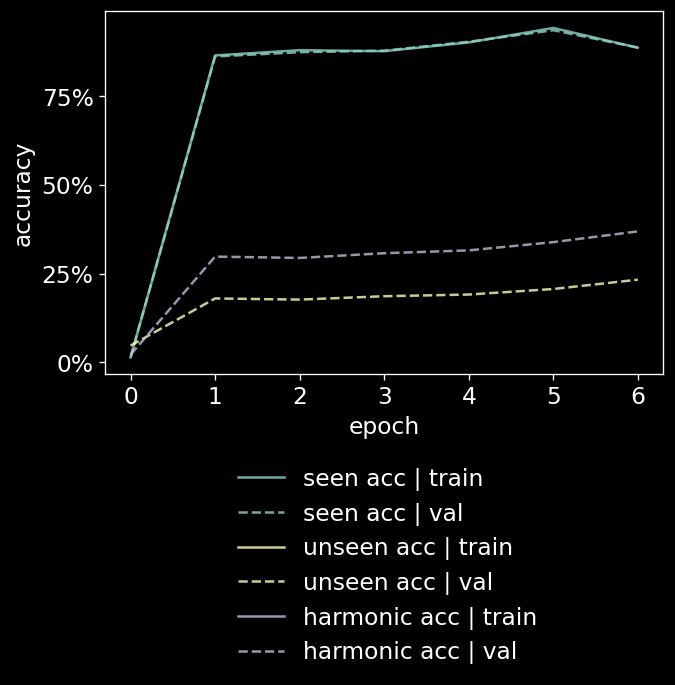

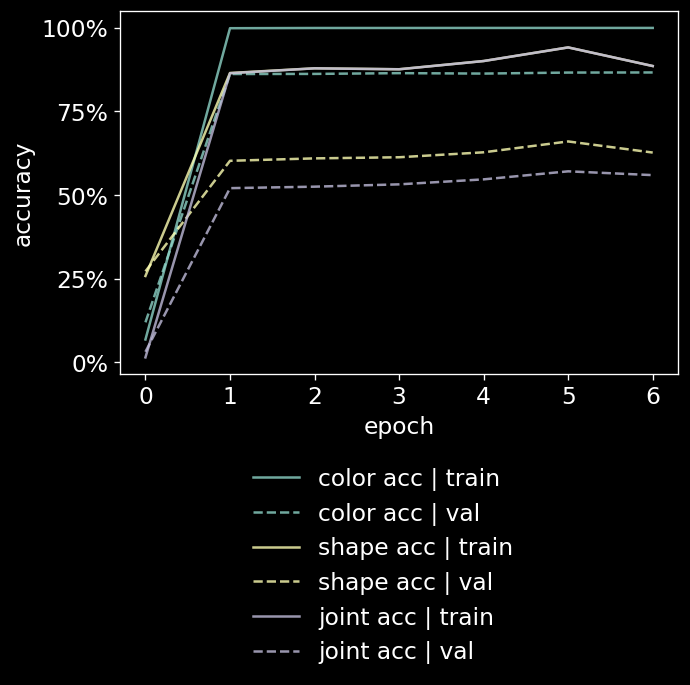

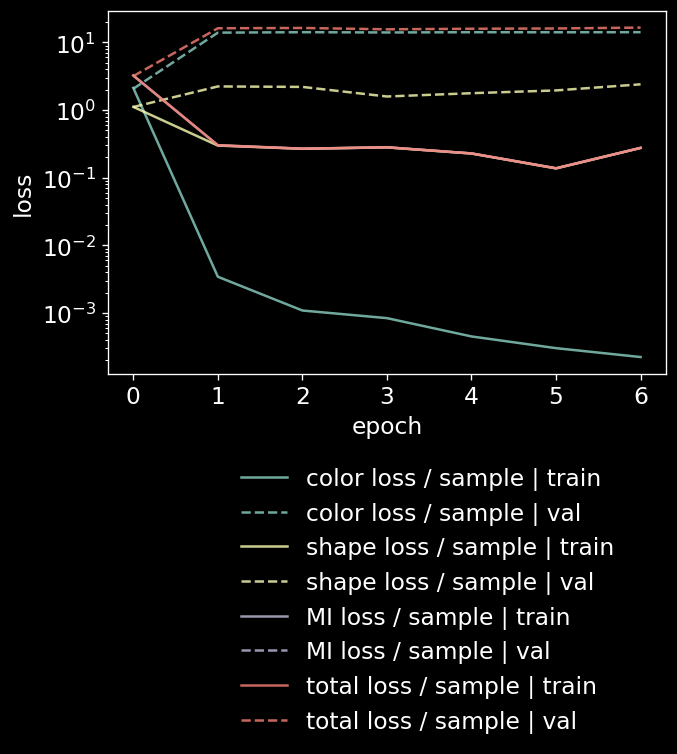

In [30]:
opacity = 0.8
# -----------------------------
acc_cols = [col for col in results_dfs['val'].columns if 'acc' in col]
main_acc_cols = ['seen acc', 'unseen acc', 'harmonic acc']
sec_acc_cols = ['color acc', 'shape acc', 'joint acc']
loss_cols = [col for col in results_dfs['val'].columns if 'loss' in col]
cols_tuples = [(main_acc_cols, 'accuracy'),
                (sec_acc_cols, 'accuracy'),
                (loss_cols, 'loss'),
            ]

for cols, ylabel in cols_tuples:
    fig = plt.figure()
    for col in cols:
        df = results_dfs['train']
        ax = plt.plot(df.index, df[col], label=f'{col} | train', alpha=opacity)
        
        df = results_dfs['val']
        plt.plot(df.index, df[col], '--', color=ax[0].get_color(), label=f'{col} | val', alpha=opacity)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    if ylabel == 'accuracy':
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        plt.locator_params(axis='y', nbins=5)
    elif ylabel == 'loss':
        plt.yscale('log')
    else:
        raise NotImplemented
    plt.legend(loc="upper left", bbox_to_anchor=(0.2, -0.2), frameon=False)

## Inference

In [31]:
unshuffled_dataloaders = {phase: torch.utils.data.DataLoader(datasets[phase],
                                                batch_size=args.batch_size, shuffle=False,
                                                num_workers=args.workers,
                                                pin_memory=args.pin_memory) for phase in datasets}
Y_color_probs, Y_shape_probs  = {}, {}

for phase in unshuffled_dataloaders:
    _, log_probs = run_epoch(training=False, models=models, dataloader=unshuffled_dataloaders[phase], clss_loss=clss_loss, args=args.VP)
    Y_color_probs[phase] = torch.exp(log_probs['color']).cpu().numpy()
    Y_shape_probs[phase] = torch.exp(log_probs['shape']).cpu().numpy()

In [32]:
Y_shape_probs

{'train': array([[9.4914675e-04, 6.5257139e-17, 9.9905080e-01],
        [1.0356392e-04, 1.5997723e-07, 9.9989629e-01],
        [4.0593798e-10, 2.9958926e-19, 1.0000000e+00],
        ...,
        [3.0362192e-01, 6.9568634e-01, 6.9167494e-04],
        [4.5893919e-01, 5.4060376e-01, 4.5710843e-04],
        [1.8120969e-02, 9.8175907e-01, 1.1997801e-04]], dtype=float32),
 'test': array([[5.1729396e-02, 9.4759429e-01, 6.7631248e-04],
        [7.2714398e-03, 9.9268156e-01, 4.6988007e-05],
        [3.4800705e-02, 9.6516269e-01, 3.6587877e-05],
        ...,
        [5.6133416e-02, 9.4379431e-01, 7.2325405e-05],
        [6.7948705e-01, 3.2036129e-01, 1.5166888e-04],
        [8.1795472e-01, 1.8177651e-01, 2.6871197e-04]], dtype=float32),
 'val': array([[9.9169660e-01, 1.9535319e-05, 8.2839252e-03],
        [5.6696028e-01, 4.1193096e-03, 4.2892042e-01],
        [9.9997407e-01, 5.4421747e-09, 2.5838439e-05],
        ...,
        [8.1899762e-01, 1.7883196e-01, 2.1703437e-03],
        [2.2717952e-03,

In [33]:
Y_shape_probs['test'][0]

array([5.1729396e-02, 9.4759429e-01, 6.7631248e-04], dtype=float32)

## Marginals EM

In [34]:
phases = list(dataloaders.keys()) + ['m.adapted test']
Y_comb['m.adapted test'] = Y_comb['test']
label_dists_df['m.adapted test samples'] = label_dists_df['test samples']
Y_color['m.adapted test'] = Y_color['test']
Y_shape['m.adapted test'] = Y_shape['test']

### Shape

In [35]:
EM_iterations = 100
# EM_iterations = 10
# -------------------------------------

shape_EM_evolution, Y_shape_probs['m.adapted test'] = basic_EM(Y=Y_shape['test'],
                                    Y_probs=Y_shape_probs['test'],
                                    prior_source = Y_shape_probs['train'].mean(0),
                                    EM_iterations=EM_iterations)

100%|██████████| 100/100 [00:00<00:00, 796.36it/s]


In [36]:
Y_shape_probs['m.adapted test'].mean(0)

array([0.56455594, 0.15926708, 0.27617493], dtype=float32)

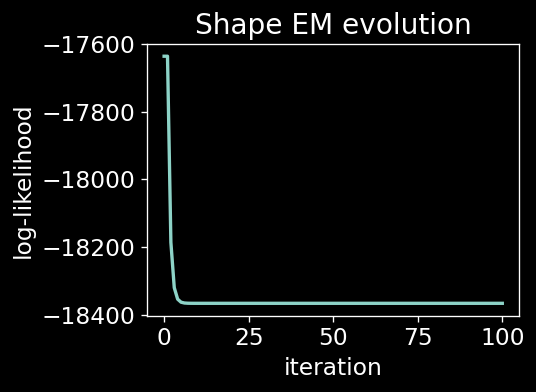

In [37]:
# metric = 'accuracy'
metric = 'log-likelihood'
# -----------------------------
plt.figure(figsize=(4,3))
shape_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
plt.ylabel(metric)
plt.title("Shape EM evolution");

### Color

In [38]:
EM_iterations = 100
# EM_iterations = 10
# -------------------------------------

color_EM_evolution, Y_color_probs['m.adapted test'] = basic_EM(Y=Y_color['test'],
                                    Y_probs=Y_color_probs['test'],
                                    prior_source = Y_color_probs['train'].mean(0),
                                    EM_iterations=EM_iterations)

C:\Program Files\KMSpico\temp\ipykernel_26032\583717110.py:66: RuntimeWarning: divide by zero encountered in log
  EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()
  0%|          | 0/100 [00:00<?, ?it/s]C:\Program Files\KMSpico\temp\ipykernel_26032\583717110.py:80: RuntimeWarning: divide by zero encountered in log
  EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()
100%|██████████| 100/100 [00:00<00:00, 646.63it/s]


In [39]:
Y_color_probs['m.adapted test'].mean(0)

array([2.1312732e-01, 1.2568896e-01, 1.6519884e-04, 1.3789214e-01,
       1.5371060e-01, 1.2717131e-01, 1.2419480e-01, 1.1804888e-01],
      dtype=float32)

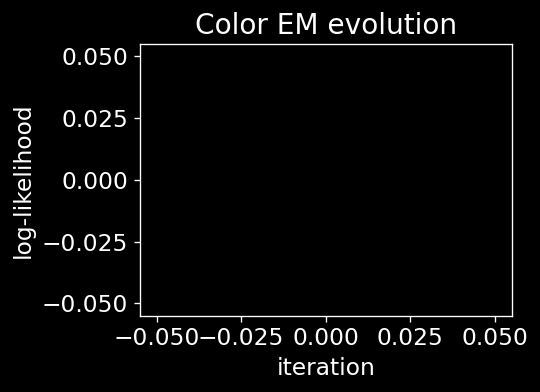

In [40]:
# metric = 'accuracy'
metric = 'log-likelihood'
# -----------------------------
plt.figure(figsize=(4,3))
color_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
plt.ylabel(metric)
plt.title("Color EM evolution");

## Marginals Evaluation

In [41]:
shape_acc = {phase: (probs.argmax(1) == Y_shape[phase]).sum() / len(Y_shape[phase]) for phase, probs in Y_shape_probs.items()}
print("shape_acc:", shape_acc)

color_acc = {phase: (probs.argmax(1) == Y_color[phase]).sum() / len(Y_shape[phase]) for phase, probs in Y_color_probs.items()}
print("color_acc:", color_acc)

shape_acc: {'train': 0.8860026186417649, 'test': 0.6411917098445595, 'val': 0.627083784368911, 'm.adapted test': 0.6312176165803108}
color_acc: {'train': 1.0, 'test': 0.8766839378238342, 'val': 0.8667460489283395, 'm.adapted test': 0.8760362694300519}


## VisProd

In [42]:
a = Y_shape_probs['test'][0]
b = Y_color_probs['test'][0]
c = []
for a_ in a:
    for b_ in b:
        c.append(a_*b_)
np.array_equal(np.array(c), np.tensordot(a, b, axes=0).flatten())

True

In [43]:
Y_VisProd_probs = {phase: np.zeros((len(Y_comb[phase]), distinct_label_n_vals['color']*distinct_label_n_vals['shape'])) for phase in phases}
for phase, probs in Y_VisProd_probs.items():
    for i in tqdm(range(len(Y_comb[phase]))):
        outer_product = np.tensordot(Y_shape_probs[phase][i], Y_color_probs[phase][i], axes=0).flatten()
        probs[i,:] = outer_product / outer_product.sum()

100%|██████████| 7720/7720 [00:00<00:00, 27154.34it/s]


In [44]:
print("EM requires probs, verify normalization:")
for phase in phases:
    print(f"(Y_VisProd_probs[{phase}].sum(axis=1) - 1).mean(): %.12f"%(Y_VisProd_probs[phase].sum(axis=1) - 1).mean())

EM requires probs, verify normalization:
(Y_VisProd_probs[train].sum(axis=1) - 1).mean(): 0.000000010153
(Y_VisProd_probs[test].sum(axis=1) - 1).mean(): 0.000000009091
(Y_VisProd_probs[val].sum(axis=1) - 1).mean(): 0.000000010147
(Y_VisProd_probs[m.adapted test].sum(axis=1) - 1).mean(): 0.000000010085


In [45]:
Y_VisProd_preds = {phase: probs.argmax(1) for phase, probs in Y_VisProd_probs.items()}
Y_VisProd_preds

{'train': array([23, 23, 23, ..., 11, 11, 11], dtype=int64),
 'test': array([13, 13, 13, ...,  8,  0,  0], dtype=int64),
 'val': array([ 6,  6,  1, ...,  0,  8, 13], dtype=int64),
 'm.adapted test': array([13, 13, 13, ...,  8,  0,  0], dtype=int64)}

In [46]:
for phase in ['train', 'test', 'm.adapted test']:
    y = Y_comb[phase]
    y_pred = Y_VisProd_preds[phase]
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'VisProd: {phase} soft pred prior'] = pd.Series(Y_VisProd_probs[phase].mean(0))
    label_dists_df[f'VisProd: {phase} true pos'] = true_pos
    label_dists_df[f'VisProd: {phase} acc'] = label_dists_df[f'VisProd: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df

,shape,color,global samples,global freq,shape idx,color idx,train samples,train freq,test samples,test freq,...,m.adapted test samples,VisProd: train soft pred prior,VisProd: train true pos,VisProd: train acc,VisProd: test soft pred prior,VisProd: test true pos,VisProd: test acc,VisProd: m.adapted test soft pred prior,VisProd: m.adapted test true pos,VisProd: m.adapted test acc
comb idx,,,,,,,,,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,0,0,6841.0,0.084501,306,0.039637,...,306,1.380951e-01,6753.0,0.987136,1.410455e-01,302.0,0.986928,0.141757,303.0,0.990196
1,cube,brown,7508,0.041711,0,1,6790.0,0.083871,342,0.044301,...,342,9.065903e-02,6784.0,0.999116,8.583122e-02,342.0,1.000000,0.087291,342.0,1.000000
2,cube,cyan,7344,0.040800,0,2,NaN,NaN,300,0.038860,...,300,1.517858e-10,NaN,NaN,5.790758e-11,NaN,NaN,0.000064,NaN,NaN
3,cube,gray,7552,0.041956,0,3,6793.0,0.083908,354,0.045855,...,354,1.203404e-01,6580.0,0.968644,6.694720e-02,342.0,0.966102,0.071060,344.0,0.971751
4,cube,green,7346,0.040811,0,4,6611.0,0.081660,345,0.044689,...,345,8.156224e-02,6610.0,0.999849,1.328530e-01,345.0,1.000000,0.140189,345.0,1.000000
5,cube,purple,7565,0.042028,0,5,NaN,NaN,300,0.038860,...,300,5.540822e-03,NaN,NaN,2.904147e-02,119.0,0.396667,0.033422,131.0,0.436667
6,cube,red,7458,0.041433,0,6,NaN,NaN,300,0.038860,...,300,5.289515e-04,NaN,NaN,2.577982e-02,127.0,0.423333,0.029042,141.0,0.470000
7,cube,yellow,7707,0.042817,0,7,NaN,NaN,300,0.038860,...,300,2.181679e-03,NaN,NaN,5.980276e-02,236.0,0.786667,0.061731,243.0,0.810000
8,cylinder,blue,7338,0.040767,1,0,6658.0,0.082240,298,0.038601,...,298,4.531848e-02,3103.0,0.466056,3.285616e-02,144.0,0.483221,0.028838,131.0,0.439597


In [47]:
closed_preds = pd.DataFrame(Y_VisProd_probs['test'][:, unseen_combs].argmax(1), columns=['unseen comb idx'])
closed_preds['comb idx'] = closed_preds['unseen comb idx'].map(unseen_combs_idx_to_comb_idx)
closed_preds['closed true pos'] = closed_preds['comb idx'] == Y_comb['test']
closed_true_pos = closed_preds.query("`closed true pos`")['comb idx'].value_counts()
label_dists_df[f'VisProd: test CLOSED true pos'] = closed_true_pos
label_dists_df

,shape,color,global samples,global freq,shape idx,color idx,train samples,train freq,test samples,test freq,...,VisProd: train soft pred prior,VisProd: train true pos,VisProd: train acc,VisProd: test soft pred prior,VisProd: test true pos,VisProd: test acc,VisProd: m.adapted test soft pred prior,VisProd: m.adapted test true pos,VisProd: m.adapted test acc,VisProd: test CLOSED true pos
comb idx,,,,,,,,,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,0,0,6841.0,0.084501,306,0.039637,...,1.380951e-01,6753.0,0.987136,1.410455e-01,302.0,0.986928,0.141757,303.0,0.990196,NaN
1,cube,brown,7508,0.041711,0,1,6790.0,0.083871,342,0.044301,...,9.065903e-02,6784.0,0.999116,8.583122e-02,342.0,1.000000,0.087291,342.0,1.000000,NaN
2,cube,cyan,7344,0.040800,0,2,NaN,NaN,300,0.038860,...,1.517858e-10,NaN,NaN,5.790758e-11,NaN,NaN,0.000064,NaN,NaN,NaN
3,cube,gray,7552,0.041956,0,3,6793.0,0.083908,354,0.045855,...,1.203404e-01,6580.0,0.968644,6.694720e-02,342.0,0.966102,0.071060,344.0,0.971751,NaN
4,cube,green,7346,0.040811,0,4,6611.0,0.081660,345,0.044689,...,8.156224e-02,6610.0,0.999849,1.328530e-01,345.0,1.000000,0.140189,345.0,1.000000,NaN
5,cube,purple,7565,0.042028,0,5,NaN,NaN,300,0.038860,...,5.540822e-03,NaN,NaN,2.904147e-02,119.0,0.396667,0.033422,131.0,0.436667,299.0
6,cube,red,7458,0.041433,0,6,NaN,NaN,300,0.038860,...,5.289515e-04,NaN,NaN,2.577982e-02,127.0,0.423333,0.029042,141.0,0.470000,188.0
7,cube,yellow,7707,0.042817,0,7,NaN,NaN,300,0.038860,...,2.181679e-03,NaN,NaN,5.980276e-02,236.0,0.786667,0.061731,243.0,0.810000,298.0
8,cylinder,blue,7338,0.040767,1,0,6658.0,0.082240,298,0.038601,...,4.531848e-02,3103.0,0.466056,3.285616e-02,144.0,0.483221,0.028838,131.0,0.439597,NaN


In [48]:
# label_dists_df[f'VisProd: test CLOSED true pos'] = true_pos

## Adapted VisProd

In [49]:
prior_source = Y_VisProd_probs['train'].mean(0)
prior_shift_pred = 1/len(label_dists_df) * np.ones((len(label_dists_df)))

adapted_VisProd_probs = Y_VisProd_probs['test'] * prior_shift_pred / prior_source
adapted_VisProd_probs = (adapted_VisProd_probs.T / adapted_VisProd_probs.sum(axis=1)).T
adapted_VisProd_probs.shape

(7720, 24)

In [50]:
phase = 'test'

y = Y_comb[phase]
y_pred = adapted_VisProd_probs.argmax(1)
true_pos = pd.Series(y[y==y_pred]).value_counts()
label_dists_df[f'adapted VisProd: {phase} soft pred prior'] = pd.Series(adapted_VisProd_probs.mean(0))
label_dists_df[f'adapted VisProd: {phase} true pos'] = true_pos
label_dists_df[f'adapted VisProd: {phase} acc'] = label_dists_df[f'adapted VisProd: {phase} true pos'] / label_dists_df[f'{phase} samples']

closed_preds = pd.DataFrame(adapted_VisProd_probs[:, unseen_combs].argmax(1), columns=['unseen comb idx'])
closed_preds['comb idx'] = closed_preds['unseen comb idx'].map(unseen_combs_idx_to_comb_idx)
closed_preds['closed true pos'] = closed_preds['comb idx'] == Y_comb['test']
closed_true_pos = closed_preds.query("`closed true pos`")['comb idx'].value_counts()
label_dists_df[f'adapted VisProd: test CLOSED true pos'] = closed_true_pos

## VisProd-EM

In [51]:
# EM_iterations = 100
# # EM_iterations = 10
# # -------------------------------------
# prior_source = Y_VisProd_probs['train'].mean(0)

# VisProd_EM_evolution, VisProd_EM_shift_probs = basic_EM(Y=Y_comb['test'],
#                                                     Y_probs=Y_VisProd_probs['test'],
#                                                     prior_source = prior_source,
#                                                     EM_iterations=EM_iterations)

In [52]:
EM_iterations = 100
# EM_iterations = 2

init_prior = 'source prior'
# init_prior = 'uniform'

prior_source_phase = 'est. soft train'
# prior_source_phase = 'est. soft test'
# prior_source_phase = 'true train'
# prior_source_phase = 'true test'
# prior_source_phase = 'uniform'

soft_prior = True # proper EM: SOFT prior_shift_pred = shift_probs.mean(axis=0)
# soft_prior = False # improper EM: HARD prior_shift_pred (calculated from hist)
over_update_probs = False # proper EM shift_probs = shift_probs_0 * prior_shift_pred / prior_train
# over_update_probs = True # improper EM shift_probs = shift_probs * prior_shift_pred / prior_train
# -------------------------------------

VisProd_EM_evolution, VisProd_EM_shift_probs = EM(Y=Y_comb, Y_probs=Y_VisProd_probs, EM_iterations=EM_iterations,
    prior_source_phase=prior_source_phase, init_prior=init_prior, n_combs=len(label_dists_df),
    soft_prior=soft_prior, over_update_probs=over_update_probs)

source prior ('est. soft train'):


array([1.38095074e-01, 9.06590268e-02, 1.51785755e-10, 1.20340407e-01,
       8.15622432e-02, 5.54082167e-03, 5.28951475e-04, 2.18167925e-03,
       4.53184839e-02, 4.75438514e-05, 9.77111668e-11, 5.67793759e-02,
       4.23642672e-05, 7.75726730e-02, 9.37978123e-05, 1.56670373e-06,
       6.71746218e-02, 7.61147080e-02, 1.07703252e-11, 7.31022152e-02,
       1.86021204e-05, 4.98598715e-05, 8.19108306e-02, 8.28651631e-02])

C:\Program Files\KMSpico\temp\ipykernel_26032\583717110.py:144: RuntimeWarning: divide by zero encountered in log
  EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()
  0%|          | 0/100 [00:00<?, ?it/s]C:\Program Files\KMSpico\temp\ipykernel_26032\583717110.py:162: RuntimeWarning: divide by zero encountered in log
  EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()
100%|██████████| 100/100 [00:00<00:00, 208.82it/s]


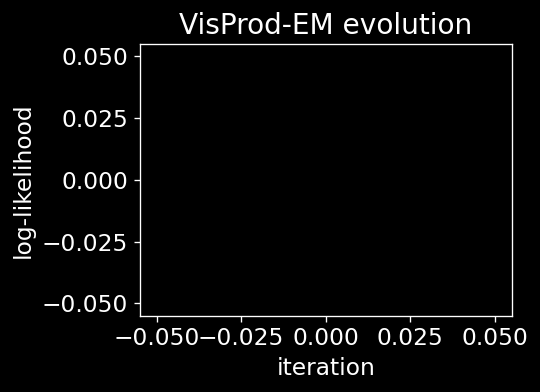

In [53]:
# metric = 'accuracy'
metric = 'log-likelihood'
# -----------------------------
plt.figure(figsize=(4,3))
VisProd_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
plt.ylabel(metric)
plt.title("VisProd-EM evolution");

In [54]:
Y_VisProdEM_preds = VisProd_EM_shift_probs.argmax(1)
Y_VisProdEM_preds

array([21, 13, 13, ...,  8,  0,  0], dtype=int64)

In [55]:
phase = 'test'

y = Y_comb[phase]
y_pred = Y_VisProdEM_preds
true_pos = pd.Series(y[y==y_pred]).value_counts()
label_dists_df[f'VisProd-EM: {phase} soft pred prior'] = pd.Series(VisProd_EM_shift_probs.mean(0))
label_dists_df[f'VisProd-EM: {phase} true pos'] = true_pos
label_dists_df[f'VisProd-EM: {phase} acc'] = label_dists_df[f'VisProd-EM: {phase} true pos'] / label_dists_df[f'{phase} samples']

closed_preds = pd.DataFrame(VisProd_EM_shift_probs[:, unseen_combs].argmax(1), columns=['unseen comb idx'])
closed_preds['comb idx'] = closed_preds['unseen comb idx'].map(unseen_combs_idx_to_comb_idx)
closed_preds['closed true pos'] = closed_preds['comb idx'] == Y_comb['test']
closed_true_pos = closed_preds.query("`closed true pos`")['comb idx'].value_counts()
label_dists_df[f'VisProd-EM: test CLOSED true pos'] = closed_true_pos
label_dists_df

,shape,color,global samples,global freq,shape idx,color idx,train samples,train freq,test samples,test freq,...,VisProd: m.adapted test acc,VisProd: test CLOSED true pos,adapted VisProd: test soft pred prior,adapted VisProd: test true pos,adapted VisProd: test acc,adapted VisProd: test CLOSED true pos,VisProd-EM: test soft pred prior,VisProd-EM: test true pos,VisProd-EM: test acc,VisProd-EM: test CLOSED true pos
comb idx,,,,,,,,,,,,,,,,,,,,,
0,cube,blue,7520,0.041778,0,0,6841.0,0.084501,306,0.039637,...,0.990196,NaN,0.101199,288.0,0.941176,NaN,1.270413e-01,303.0,0.990196,NaN
1,cube,brown,7508,0.041711,0,1,6790.0,0.083871,342,0.044301,...,1.000000,NaN,0.071852,286.0,0.836257,NaN,8.397607e-02,341.0,0.997076,NaN
2,cube,cyan,7344,0.040800,0,2,NaN,NaN,300,0.038860,...,NaN,NaN,0.004265,NaN,NaN,NaN,1.113488e-29,NaN,NaN,NaN
3,cube,gray,7552,0.041956,0,3,6793.0,0.083908,354,0.045855,...,0.971751,NaN,0.055211,312.0,0.881356,NaN,6.668958e-02,342.0,0.966102,NaN
4,cube,green,7346,0.040811,0,4,6611.0,0.081660,345,0.044689,...,1.000000,NaN,0.064873,239.0,0.692754,NaN,6.652788e-02,253.0,0.733333,NaN
5,cube,purple,7565,0.042028,0,5,NaN,NaN,300,0.038860,...,0.436667,299.0,0.039540,206.0,0.686667,257.0,3.863293e-02,200.0,0.666667,245.0
6,cube,red,7458,0.041433,0,6,NaN,NaN,300,0.038860,...,0.470000,188.0,0.030638,146.0,0.486667,152.0,2.581491e-02,131.0,0.436667,139.0
7,cube,yellow,7707,0.042817,0,7,NaN,NaN,300,0.038860,...,0.810000,298.0,0.067232,250.0,0.833333,263.0,7.663352e-02,283.0,0.943333,290.0
8,cylinder,blue,7338,0.040767,1,0,6658.0,0.082240,298,0.038601,...,0.439597,NaN,0.037699,187.0,0.627517,NaN,2.177497e-02,117.0,0.392617,NaN


## Calibration

### Calibration evaluation before

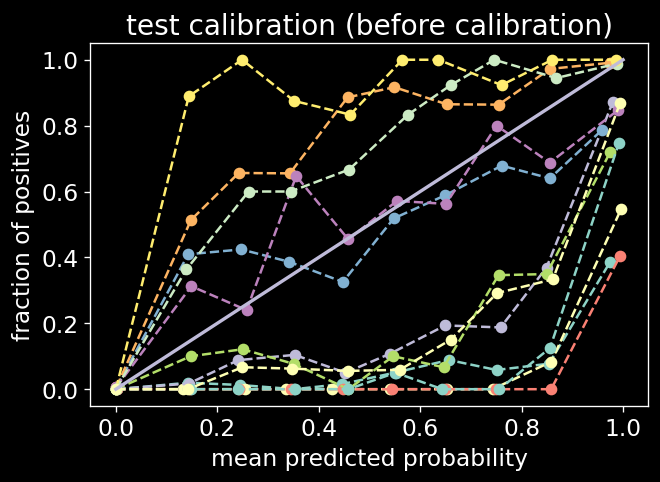

In [56]:
n_bins = 10
# ----------------

plt.figure()
ref = np.linspace(0, 1, n_bins)

for i_comb in seen_combs:
    prob_true, prob_pred = calibration_curve(y_true=Y_comb['test'] == i_comb,
        y_prob=Y_VisProd_probs['test'][:,i_comb], n_bins=n_bins)
    plt.plot(prob_pred, prob_true, 'o--', label=f"comb {i_comb}")

plt.plot(ref, ref, '-', label='perfect calibration', linewidth=2)

plt.title("test calibration (before calibration)")
# plt.legend(fontsize=12, frameon=False)
plt.xlabel("mean predicted probability")
plt.ylabel("fraction of positives")
plt.show()

### Calibration

In [57]:
# multi_class = 'ovr'
multi_class = 'multinomial'
# multi_class = 'none'

max_iter = 1000 # default: 100
# ------------------------------

if args.VP.calibrate:
    if multi_class == 'none':
        for phase in phases:
            Y_VisProd_probs[f'{phase}_calib'] = np.zeros_like(Y_VisProd_probs[phase])
            Y_comb_VP[f'{phase}_calib'] = Y_comb_VP[phase]

        for i_comb in tqdm(range(Y_VisProd_probs['held-out'].shape[1])):
            if (Y_comb_VP['train'] == i_comb).sum() > 0:
                comb_seen = True
            else:
                comb_seen = False

            y = (Y_comb_VP['held-out'] == i_comb)
            if comb_seen: # can calibrate only if i_comb is seen - contains samples
                calibrator = LogisticRegression(penalty='none', max_iter=max_iter)
                calibrator.fit(X=Y_VisProd_probs['held-out'][:,i_comb].reshape(-1, 1), y=y)
            
            for phase in phases:
                if comb_seen:
                    Y_VisProd_probs[f'{phase}_calib'][:,i_comb] = calibrator.predict_proba(
                        Y_VisProd_probs[phase][:,i_comb].reshape(-1, 1))[:,1]
                else:
                    Y_VisProd_probs[f'{phase}_calib'][:,i_comb] = Y_VisProd_probs[phase][:,i_comb]
    else:
        # raise NotImplemented
        for phase in phases:
            Y_VisProd_probs[f'{phase}_calib'] = Y_VisProd_probs[phase].copy()
            Y_comb_VP[f'{phase}_calib'] = Y_comb_VP[phase]
        
        hard_seen_combs = label_dists_df.query('`train samples` > 0').index
        y = Y_comb_VP['held-out']
        hard_seen_combs_y = y.copy()
        hard_seen_combs_y[~np.isin(y, hard_seen_combs)] = 0
        calibrator = LogisticRegression(penalty='none', max_iter=max_iter, multi_class=multi_class)
        calibrator.fit(X=Y_VisProd_probs['held-out'][:,hard_seen_combs], y=hard_seen_combs_y)
        for phase in phases:
                Y_VisProd_probs[f'{phase}_calib'][:,hard_seen_combs] = calibrator.predict_proba(
                    Y_VisProd_probs[phase][:,hard_seen_combs])
        
    
    for phase in ['train', 'test']:
        y = Y_comb_VP[f'{phase}_calib']
        y_pred = Y_VisProd_probs[f'{phase}_calib'].argmax(1)
        true_pos = pd.Series(y[y==y_pred]).value_counts()
        label_dists_df[f'calib VisProd: {phase} acc'] = label_dists_df[f'VisProd: {phase} true pos'] / label_dists_df[f'{phase} samples']
    # display(label_dists_df)

### Calibration evaluation after

In [58]:
n_bins = 10
# ----------------

if args.VP.calibrate:
    for phase in ['held-out', 'test']:
        plt.figure()
        ref = np.linspace(0, 1, n_bins)

        for i_comb in seen_combs:
            prob_true, prob_pred = calibration_curve(y_true=Y_comb_VP[f'{phase}_calib'] == i_comb,
                y_prob=Y_VisProd_probs[f'{phase}_calib'][:,i_comb], n_bins=n_bins)
            plt.plot(prob_pred, prob_true, 'o--', label=f"comb {i_comb}")

        plt.plot(ref, ref, '-', label='perfect calibration', linewidth=2)

        plt.title(f"{phase} calibration (after calibration)")
        # plt.legend(fontsize=12, frameon=False)
        plt.xlabel("mean predicted probability")
        plt.ylabel("fraction of positives")
        plt.show()

## Calib. VisProd-EM

In [59]:
EM_iterations = 100
# EM_iterations = 10
# -------------------------------------

if args.VP.calibrate:
    prior_source = Y_VisProd_probs['train_calib'].mean(0)

    calib_VisProd_EM_evolution, calib_VisProd_EM_shift_probs = basic_EM(Y=Y_comb_VP['test_calib'],
                                                        Y_probs=Y_VisProd_probs['test_calib'],
                                                        prior_source = prior_source,
                                                        EM_iterations=EM_iterations)

In [60]:
# metric = 'accuracy'
metric = 'log-likelihood'
# -----------------------------

if args.VP.calibrate:
    plt.figure(figsize=(4,3))
    calib_VisProd_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
    plt.ylabel(metric)
    plt.title("Calib. VisProd-EM evolution")

In [61]:
if args.VP.calibrate:
    phase = 'test'

    y = Y_comb_VP[phase]
    y_pred = calib_VisProd_EM_shift_probs.argmax(1)
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'calib VisProd-EM: {phase} soft pred prior'] = pd.Series(VisProd_EM_shift_probs.mean(0))
    label_dists_df[f'calib VisProd-EM: {phase} true pos'] = true_pos
    label_dists_df[f'calib VisProd-EM: {phase} acc'] = label_dists_df[f'calib VisProd-EM: {phase} true pos'] / label_dists_df[f'{phase} samples']

    closed_preds = pd.DataFrame(calib_VisProd_EM_shift_probs[:, unseen_combs].argmax(1), columns=['unseen comb idx'])
    closed_preds['comb idx'] = closed_preds['unseen comb idx'].map(unseen_combs_idx_to_comb_idx)
    closed_preds['closed true pos'] = closed_preds['comb idx'] == Y_comb_VP['test']
    closed_true_pos = closed_preds.query("`closed true pos`")['comb idx'].value_counts()
    label_dists_df[f'calib VisProd-EM: test CLOSED true pos'] = closed_true_pos
    label_dists_df

# Summary

## Macro (per-combination) results

In [62]:
acc_result_cols = [col for col in label_dists_df.columns if 'acc' in col]
macro_result_cols = label_cols + ['state', 'train freq', 'test freq'] + acc_result_cols

macro_results_df = label_dists_df[macro_result_cols]
# results_df = results_df.sort_values(by='train freq', ascending=False)
with pd.option_context('display.float_format',"{:,.3%}".format):
    display(macro_results_df)

,shape,color,state,train freq,test freq,VisProd: train acc,VisProd: test acc,VisProd: m.adapted test acc,adapted VisProd: test acc,VisProd-EM: test acc
comb idx,,,,,,,,,,
0,cube,blue,seen,8.450%,3.964%,98.714%,98.693%,99.020%,94.118%,99.020%
1,cube,brown,seen,8.387%,4.430%,99.912%,100.000%,100.000%,83.626%,99.708%
2,cube,cyan,unseen,NaN,3.886%,NaN,NaN,NaN,NaN,NaN
3,cube,gray,seen,8.391%,4.585%,96.864%,96.610%,97.175%,88.136%,96.610%
4,cube,green,seen,8.166%,4.469%,99.985%,100.000%,100.000%,69.275%,73.333%
5,cube,purple,unseen,NaN,3.886%,NaN,39.667%,43.667%,68.667%,66.667%
6,cube,red,unseen,NaN,3.886%,NaN,42.333%,47.000%,48.667%,43.667%
7,cube,yellow,unseen,NaN,3.886%,NaN,78.667%,81.000%,83.333%,94.333%
8,cylinder,blue,seen,8.224%,3.860%,46.606%,48.322%,43.960%,62.752%,39.262%


In [63]:
with pd.option_context('display.float_format',"{:,.3%}".format):
    # display(results_df.groupby(by=label_cols).mean())
    display(macro_results_df.groupby(by='color').mean())

,train freq,test freq,VisProd: train acc,VisProd: test acc,VisProd: m.adapted test acc,adapted VisProd: test acc,VisProd-EM: test acc
color,,,,,,,
blue,8.352%,4.141%,75.569%,75.202%,72.636%,79.332%,70.601%
brown,8.342%,4.188%,96.703%,64.450%,63.729%,65.093%,64.892%
cyan,NaN,3.886%,NaN,NaN,NaN,NaN,NaN
gray,8.341%,4.603%,82.465%,83.036%,79.393%,81.854%,83.301%
green,8.166%,4.080%,99.985%,41.222%,40.222%,59.092%,58.889%
purple,8.317%,4.214%,97.475%,63.825%,63.537%,79.067%,77.515%
red,8.252%,4.136%,99.656%,59.018%,60.258%,70.726%,70.894%
yellow,8.502%,4.085%,98.286%,88.755%,89.777%,60.813%,90.664%


In [64]:
# macro_result_summary_dict = {}
# for state in ['seen', 'unseen']:
#     macro_result_summary_dict[state] = macro_results_df.query(f"state == '{state}'")[acc_result_cols].fillna(0).mean(0)
# macro_result_summary_dict['all'] = macro_results_df[acc_result_cols].fillna(0).mean(0)
# macro_result_summary_df = pd.DataFrame.from_dict(macro_result_summary_dict, orient='index')
# macro_result_summary_df.columns = macro_result_summary_df.columns.str.replace('acc', '')

# acc_seen = macro_result_summary_df.loc['seen']
# acc_unseen = macro_result_summary_df.loc['unseen']
# macro_result_summary_df.loc['harmonic'] = 2*acc_seen*acc_unseen/(acc_seen+acc_unseen)

# print("macro accuracy results:")
# with pd.option_context('display.float_format',"{:,.1%}".format):
#     display(macro_result_summary_df)
#     print("DON'T USE, macro results!")

## MAIN: Micro metrics

In [65]:
pos_result_cols = [col for col in label_dists_df.columns if 'true pos' in col]
open_pos_result_cols = [col for col in pos_result_cols if 'CLOSED' not in col]
closed_pos_result_cols = [col for col in pos_result_cols if 'CLOSED' in col]
samples_cols = [col for col in label_dists_df.columns if 'samples' in col]
micro_result_cols = label_cols + ['state'] + samples_cols + pos_result_cols

micro_results_df = label_dists_df[micro_result_cols]
with pd.option_context('display.float_format',"{:,.0f}".format):
    display(micro_results_df)

,shape,color,state,global samples,train samples,test samples,val samples,m.adapted test samples,VisProd: train true pos,VisProd: test true pos,VisProd: m.adapted test true pos,VisProd: test CLOSED true pos,adapted VisProd: test true pos,adapted VisProd: test CLOSED true pos,VisProd-EM: test true pos,VisProd-EM: test CLOSED true pos
comb idx,,,,,,,,,,,,,,,,
0,cube,blue,seen,7520,"6,841",306,373,306,"6,753",302,303,NaN,288,NaN,303,NaN
1,cube,brown,seen,7508,"6,790",342,376,342,"6,784",342,342,NaN,286,NaN,341,NaN
2,cube,cyan,unseen,7344,NaN,300,385,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cube,gray,seen,7552,"6,793",354,405,354,"6,580",342,344,NaN,312,NaN,342,NaN
4,cube,green,seen,7346,"6,611",345,390,345,"6,610",345,345,NaN,239,NaN,253,NaN
5,cube,purple,unseen,7565,NaN,300,385,300,NaN,119,131,299,206,257,200,245
6,cube,red,unseen,7458,NaN,300,385,300,NaN,127,141,188,146,152,131,139
7,cube,yellow,unseen,7707,NaN,300,385,300,NaN,236,243,298,250,263,283,290
8,cylinder,blue,seen,7338,"6,658",298,382,298,"3,103",144,131,NaN,187,NaN,117,NaN


In [66]:
models = set([name.split(':')[0] for name in pos_result_cols])
models

{'VisProd', 'VisProd-EM', 'adapted VisProd'}

In [67]:
micro_result_summary_dict = {}
for state in ['seen', 'unseen']:
    micro_result_summary_dict[state] = micro_results_df.query(f"state == '{state}'")[open_pos_result_cols].sum(0)
micro_result_summary_dict['all'] = micro_results_df[open_pos_result_cols].sum(0)
micro_result_summary_df = pd.DataFrame.from_dict(micro_result_summary_dict, orient='index')

# from positives to accuracy
for col in micro_result_summary_df.columns:
    phase = col.split(': ')[1].split(' true')[0]
    micro_result_summary_df.loc['seen', col] /= micro_results_df.query("state == 'seen'")[f'{phase} samples'].sum()
    micro_result_summary_df.loc['unseen', col] /= micro_results_df.query("state == 'unseen'")[f'{phase} samples'].sum()
    micro_result_summary_df.loc['all', col] /= micro_results_df[f'{phase} samples'].sum()
micro_result_summary_df.columns = micro_result_summary_df.columns.str.replace("true pos", '')

acc_seen = micro_result_summary_df.loc['seen']
acc_unseen = micro_result_summary_df.loc['unseen']
micro_result_summary_df.loc['harmonic'] = 2*acc_seen*acc_unseen/(acc_seen+acc_unseen)

for col in closed_pos_result_cols:
    micro_result_summary_df.loc['closed', col.replace('CLOSED true pos', '')] = micro_results_df[col].sum(0) / micro_results_df.query("state == 'unseen'")['test samples'].sum()

print("micro accuracy results:")
with pd.option_context('display.float_format',"{:,.1%}".format):
    display(micro_result_summary_df)

micro accuracy results:


C:\Program Files\KMSpico\temp\ipykernel_26032\176674401.py:11: RuntimeWarning: invalid value encountered in double_scalars
  micro_result_summary_df.loc['unseen', col] /= micro_results_df.query("state == 'unseen'")[f'{phase} samples'].sum()


,VisProd: train,VisProd: test,VisProd: m.adapted test,adapted VisProd: test,VisProd-EM: test
seen,88.6%,88.8%,86.9%,82.0%,81.3%
unseen,NaN,22.9%,23.1%,42.0%,40.4%
all,88.6%,58.1%,57.2%,63.3%,62.2%
harmonic,NaN,36.4%,36.6%,55.5%,54.0%
closed,NaN,51.7%,NaN,53.5%,51.6%


In [68]:
# acc_seen = 0.8
# acc_unseen = 0.4
# 2*acc_seen*acc_unseen/(acc_seen+acc_unseen)

## Predicted prior

In [69]:
soft_prior_cols = [col for col in label_dists_df.columns if 'soft' in col]
with pd.option_context('display.float_format',"{:,.1%}".format):
    # display(label_dists_df[label_cols + ['state', 'train freq', 'test freq'] + soft_prior_cols].query("state == 'unseen'"))
    display(label_dists_df[label_cols + ['state', 'train freq', 'test freq'] + soft_prior_cols].sort_values(by='state'))
# label_dists_df[label_cols + ['state', 'train freq', 'test freq'] + soft_prior_cols].sort_values(by='state').style.format("{:.1%}").background_gradient(cmap='Greens')

,shape,color,state,train freq,test freq,VisProd: train soft pred prior,VisProd: test soft pred prior,VisProd: m.adapted test soft pred prior,adapted VisProd: test soft pred prior,VisProd-EM: test soft pred prior
comb idx,,,,,,,,,,
0,cube,blue,seen,8.5%,4.0%,13.8%,14.1%,14.2%,10.1%,12.7%
19,sphere,gray,seen,8.2%,4.3%,7.3%,3.9%,3.7%,3.5%,3.8%
17,sphere,brown,seen,8.3%,4.2%,7.6%,3.9%,3.8%,4.0%,3.8%
16,sphere,blue,seen,8.4%,4.6%,6.7%,4.5%,4.3%,4.0%,3.6%
13,cylinder,purple,seen,8.3%,4.9%,7.8%,7.8%,7.5%,3.8%,3.4%
22,sphere,red,seen,8.3%,4.6%,8.2%,7.4%,7.2%,4.6%,4.7%
8,cylinder,blue,seen,8.2%,3.9%,4.5%,3.3%,2.9%,3.8%,2.2%
11,cylinder,gray,seen,8.4%,4.9%,5.7%,3.2%,3.0%,3.7%,3.3%
4,cube,green,seen,8.2%,4.5%,8.2%,13.3%,14.0%,6.5%,6.7%


Text(0.5, 0, 'comb idx')

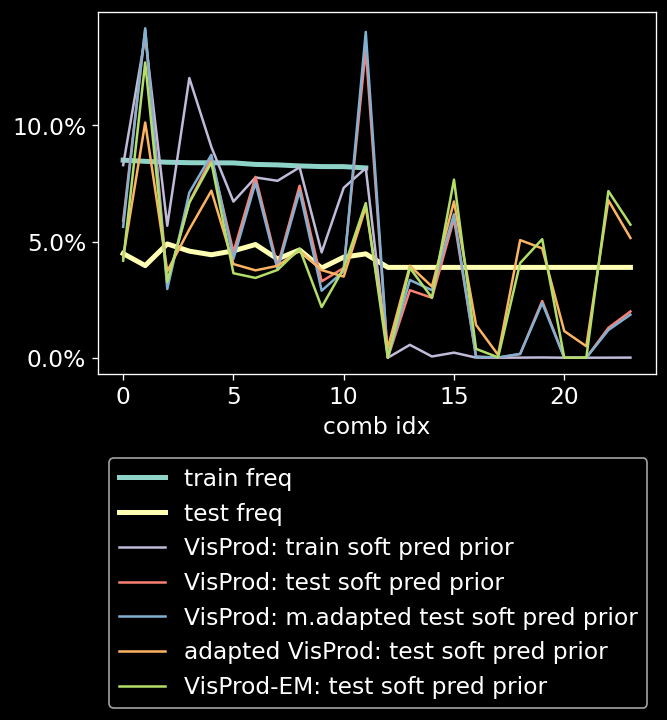

In [70]:
df = label_dists_df.copy()
df = df.sort_values(by='train freq', ascending=False)
df.index = range(len(df))

df[['train freq', 'test freq']].plot(linewidth=3)
df[soft_prior_cols].plot(ax=plt.gca())
plt.legend(loc="upper left", bbox_to_anchor=(0, -0.2))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.locator_params(axis='y', nbins=4)
plt.xlabel('comb idx')

In [71]:
show_total = True
# ----------------------

for prior in soft_prior_cols:
    print(f"{prior}:")
    with pd.option_context('display.float_format',"{:,.1%}".format):
        df = label_dists_df.pivot(index=label_cols[0], columns=label_cols[1], values=prior)
        df_ = df.copy()
        if show_total:
            df_['total'] = df.sum(1)
            df_.loc['total'] = df.sum(0)
        display(df_)

VisProd: train soft pred prior:


color,blue,brown,cyan,gray,green,purple,red,yellow,total
shape,,,,,,,,,
cube,13.8%,9.1%,0.0%,12.0%,8.2%,0.6%,0.1%,0.2%,43.9%
cylinder,4.5%,0.0%,0.0%,5.7%,0.0%,7.8%,0.0%,0.0%,18.0%
sphere,6.7%,7.6%,0.0%,7.3%,0.0%,0.0%,8.2%,8.3%,38.1%
total,25.1%,16.7%,0.0%,25.0%,8.2%,8.3%,8.3%,8.5%,NaN


VisProd: test soft pred prior:


color,blue,brown,cyan,gray,green,purple,red,yellow,total
shape,,,,,,,,,
cube,14.1%,8.6%,0.0%,6.7%,13.3%,2.9%,2.6%,6.0%,54.1%
cylinder,3.3%,0.0%,0.0%,3.2%,0.2%,7.8%,2.4%,0.0%,17.0%
sphere,4.5%,3.9%,0.0%,3.9%,1.3%,2.0%,7.4%,5.9%,28.9%
total,21.9%,12.6%,0.0%,13.8%,14.7%,12.7%,12.4%,11.9%,NaN


VisProd: m.adapted test soft pred prior:


color,blue,brown,cyan,gray,green,purple,red,yellow,total
shape,,,,,,,,,
cube,14.2%,8.7%,0.0%,7.1%,14.0%,3.3%,2.9%,6.2%,56.5%
cylinder,2.9%,0.0%,0.0%,3.0%,0.2%,7.5%,2.4%,0.0%,15.9%
sphere,4.3%,3.8%,0.0%,3.7%,1.2%,1.9%,7.2%,5.6%,27.6%
total,21.3%,12.6%,0.0%,13.8%,15.4%,12.7%,12.4%,11.8%,NaN


adapted VisProd: test soft pred prior:


color,blue,brown,cyan,gray,green,purple,red,yellow,total
shape,,,,,,,,,
cube,10.1%,7.2%,0.4%,5.5%,6.5%,4.0%,3.1%,6.7%,43.5%
cylinder,3.8%,1.4%,0.1%,3.7%,5.1%,3.8%,4.7%,1.1%,23.7%
sphere,4.0%,4.0%,0.5%,3.5%,6.8%,5.2%,4.6%,4.3%,32.8%
total,17.9%,12.5%,1.0%,12.7%,18.3%,12.9%,12.4%,12.2%,NaN


VisProd-EM: test soft pred prior:


color,blue,brown,cyan,gray,green,purple,red,yellow,total
shape,,,,,,,,,
cube,12.7%,8.4%,0.0%,6.7%,6.7%,3.9%,2.6%,7.7%,48.5%
cylinder,2.2%,0.4%,0.0%,3.3%,4.1%,3.4%,5.1%,0.0%,18.4%
sphere,3.6%,3.8%,0.0%,3.8%,7.2%,5.7%,4.7%,4.2%,33.0%
total,18.5%,12.6%,0.0%,13.8%,17.9%,13.0%,12.4%,11.8%,NaN


# INTENTIONAL BREAK

In [72]:
raise RuntimeError("intentionally stopping here before next sections")

RuntimeError: intentionally stopping here before next sections

# Multi-class on combinations (CE)

## Net initialization

In [ ]:
device = torch_setup(deterministic=True)
seed_all(args.init_seed)

in_dim = X['train'].shape[1]
out_dim = len(global_label_combs)

assert in_dim == 512
Net_combs = nn.Sequential(
    nn.Linear(in_dim, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 64),
    nn.ELU(inplace=True),
    nn.Linear(64, out_dim),
)
cp = Checkpoint(dirname='checkpoints\combs_net', monitor='valid_acc_best', load_best=True)
net_combs = NeuralNetClassifier(
    Net_combs,
    max_epochs=10,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.SGD,
    lr=2e-1,
    batch_size=args.batch_size,
    iterator_train__shuffle=True,
    train_split=ValidSplit(cv=args.skorch_val_ratio, stratified=True),
    device=device,
    callbacks=[EpochScoring(scoring='accuracy', lower_is_better=False, on_train=True), cp],
)
net_combs

## Training

In [ ]:
net_combs.fit(X['train'], Y_comb['train']);

## Evaluation

In [ ]:
Y_comb_probs = {phase: net_combs.predict_proba(X[phase]) for phase in ['train', 'test']}
for phase in ['train', 'test']:
#     assert set(np.unique(Y[phase])) == {0,1} # "EM below assumes labels are binary!"
    print(f"(Y_comb_probs[{phase}].sum(axis=1) - 1).mean(): %.12f"%(Y_comb_probs[phase].sum(axis=1) - 1).mean())
#     print(f"Y_comb_probs[{phase}].sum(axis=1)")
#     display(Y_comb_probs[phase].sum(axis=1))
    # assert (Y_comb_probs[phase].sum(axis=1) - 1).mean() == 0, 'EM requires probs (normalized)!'
Y_comb_probs['test']

In [ ]:
Y_comb_pred = {phase: Y_comb_probs[phase].argmax(axis=1) for phase in ['train', 'test']}
Y_comb_pred['test']

In [ ]:
for phase in ['train', 'test']:
    y = Y_comb[phase]
    y_pred = Y_comb_pred[phase]
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'multi-class: {phase} soft pred prior'] = pd.Series(Y_comb_probs[phase].mean(0))
    label_dists_df[f'multi-class: {phase} true pos'] = true_pos
    label_dists_df[f'multi-class: {phase} acc'] = label_dists_df[f'multi-class: {phase} true pos'] / label_dists_df[f'{phase} samples']
# label_dists_df

In [ ]:
# result_cols = ['train freq', 'test freq', 'multi-class: train acc', 'multi-class: test acc']
# results_df = label_dists_df[result_cols].sort_values(by='train freq', ascending=False)
# results_df_styled = results_df.style.format("{:.1%}").background_gradient(cmap='Greens')
# results_df_styled

In [ ]:
# result_cols = label_cols + ['train freq', 'test freq', 'multi-class: train acc', 'multi-class: test acc']
# results_df = label_dists_df[result_cols]
# # results_df = results_df.sort_values(by='train freq', ascending=False)
# with pd.option_context('display.float_format',"{:,.1%}".format):
#     display(results_df)

In [ ]:
# for phase in ['train', 'test']:
#     print(f'multi-class combs net - {phase} soft predicted prior (mean of probs):')
#     with pd.option_context('display.float_format',"{:,.1%}".format):
#         display(label_dists_df.pivot(index='shape', columns='color', values=f'multi-class: {phase} soft pred prior'))

# Information - MI, entropy

* https://docs.google.com/document/d/148N5UL_qCk7LT10OyFp4wG9QvipNJ-Mphieo5Yu6TzA/edit#heading=h.eonun6y2wp8l
* https://en.wikipedia.org/wiki/Information_theory 
* https://en.wikipedia.org/wiki/Mutual_information
* https://en.wikipedia.org/wiki/Conditional_entropy

## Entropies

In [ ]:
phase = 'train'
# ------------------
for model, probs in [('shape', Y_shape_probs[phase]), ('color', Y_color_probs[phase])]:
    entropy = -probs * np.log(probs)
    print(f"{model} entropy:")
    print(entropy.mean(0))

## Using joint dist ground truth

In [ ]:
mutual_info = {}
mean_pred_prob = {}

for phase in ['train', 'test']:
    p_x_p_y = np.take_along_axis(Y_VisProd_probs[phase], Y_comb[phase].reshape(-1,1), axis=1)
    mean_pred_prob[phase] = p_x_p_y.mean()
    mutual_info[phase] = np.log(1/p_x_p_y).mean()
print("mutual_info:", mutual_info)
print("mean probability of the predicted joint combination:", mean_pred_prob)

In [ ]:
phase = 'train'
# ------------------
info_df = pd.DataFrame(index=range(len(Y_comb[phase])))
info_df['comb idx'] = Y_comb[phase]
info_df['MI'] = np.log(1/np.take_along_axis(Y_VisProd_probs[phase], Y_comb[phase].reshape(-1,1), axis=1))
info_df

In [ ]:
# label_dists_df.columns

In [ ]:
dist_ = label_dists_df[['shape', 'color', f'{phase} samples', f'VisProd: {phase} acc']].copy()
dist_[f'{phase} mean MI'] = info_df.groupby('comb idx').mean()
with pd.option_context('display.float_format',"{:,.1e}".format):
    df = dist_.pivot(index=label_cols[0], columns=label_cols[1], values=f'{phase} mean MI')
    print(f'{phase} mean MI - using g.t. comb labels:')
    display(df)
    print("micro mean: %.1e"%(info_df['MI'].mean()))

## Using joint dist estimator

In [ ]:
phase = 'train'
joint_probs = Y_comb_probs[phase]
outer_prod_probs = Y_VisProd_probs[phase]
# joint_probs = Y_comb_probs['train'][:, seen_combs]
# outer_prod_probs = Y_VisProd_probs['train'][:, seen_combs]
eps = 0
# ---------------
eps_vect = eps * np.ones(outer_prod_probs.shape[1])
# copula = (joint_probs) / (outer_prod_probs + eps_vect)
copula = (outer_prod_probs) / (joint_probs + eps_vect)
copula.mean(0)

In [ ]:
nullify_unseen = True
# -------------------------------

dist_ = label_dists_df[['shape', 'color', f'{phase} samples', f'VisProd: {phase} acc']].copy()
dist_[f'{phase} VisProd / joint prob'] = copula.mean(0)

mutual_info = outer_prod_probs * np.log(copula)
mutual_info[outer_prod_probs==0] = 0
dist_[f'{phase} MI'] = mutual_info.mean(0)

if nullify_unseen:
    dist_.loc[unseen_combs, f'{phase} VisProd / joint prob'] = np.NaN
    dist_.loc[unseen_combs, f'{phase} MI'] = np.NaN
    mutual_info = mutual_info[:, seen_combs]

In [ ]:
with pd.option_context('display.float_format',"{:,.1e}".format):
    df = dist_.pivot(index=label_cols[0], columns=label_cols[1], values=f'{phase} VisProd / joint prob')
    print(f'{phase} mean VisProd prob / estimated comb prob:')
    display(df)

    print(f'{phase} mean MI - using joint prob estimator:')
    df = dist_.pivot(index=label_cols[0], columns=label_cols[1], values=f'{phase} MI')
    display(df)
    if nullify_unseen:
        print("seen - micro mean: %.1e"%(mutual_info.mean()))
    else:
        print("micro mean: %.1e"%(mutual_info.mean()))

# Aggregated analysis

## Unseen-ratio repetitions

In [ ]:
comparison_df = pd.read_excel('analysis\AO-Clevr 5000.xlsx')
comparison_df = comparison_df.fillna(0)
comparison_df

In [ ]:
y_col = 'full EM: test acc'
# y_col = 'multi-class: test acc'
# ---------------------------
sns.lineplot(data=comparison_df, x='ratio', y=y_col, hue='state', marker="o")
plt.legend(title='', frameon=False)
plt.xscale('symlog', linthresh=1e-3)

## Experiment repetitions

In [ ]:
exp_dir = 'analysis/MLLS/basic exp'
# ----------------------------------------
exp_names = [name for name in os.listdir(exp_dir) if '.xlsx' in name]
exp_names

In [ ]:
# for exp_name in exp_names:
#     name_parts = exp_name.split()
#     num_split = name_parts[0].split('=')[0]
#     init_seed = name_parts[1].split('=')[0]
results_dfs = []
for num_split in [5000]:
    for init_seed in [0, 1, 2]:
        exp_name = f"VT={num_split} init_seed={init_seed}.xlsx"

        results_df = pd.read_excel(pjoin(exp_dir,exp_name), index_col=0)
        
        results_df['num_split'] = num_split
        results_df['init_seed'] = init_seed
        results_dfs.append(results_df)

results_df = pd.concat(results_dfs, axis=0)
results_df

In [ ]:
result_cols = results_df.columns[~results_df.columns.isin(['num_split', 'init_seed'])]
means_df = results_df.groupby('metric').mean()
sems_df = results_df.groupby('metric').sem(ddof=0)

agg_results_dict = {}
for metric in results_df.index:
    agg_results_dict[metric] = {}
    for model in result_cols:
        mean = means_df.loc[metric, model]
        sem = sems_df.loc[metric, model]
        agg_results_dict[metric][model] = "%.1f ± %.1f"%(100*mean, 100*sem)
agg_results_df = pd.DataFrame(agg_results_dict)
agg_results_df[['seen', 'unseen', 'harmonic', 'closed']]

# Full EM

## Adding noise to unseen combs

In [ ]:
EM_meta_df = label_dists_df[['train freq', 'test freq']].copy()
EM_meta_df['mean test prob'] = Y_comb_probs['test'].mean(0)
EM_meta_df

In [ ]:
seen_mean_prob = EM_meta_df.loc[~EM_meta_df['train freq'].isna() ,'mean test prob'].mean()
unseen_mean_prob = EM_meta_df.loc[EM_meta_df['train freq'].isna() ,'mean test prob'].mean()
print("mean prob - seen, unseen = %.2e, %.2e"%(seen_mean_prob, unseen_mean_prob))

In [ ]:
# factor = np.ones_like(Y_comb_probs['test'])
# factor[:, label_dists_df['train freq'].isna().values] = 100
# factor[0][label_dists_df['train freq'].isna().values]

## EM

In [ ]:
EM_iterations = 100
# EM_iterations = 10

init_prior = 'source prior'
# init_prior = 'uniform'

prior_source_phase = 'est. soft train'
# prior_source_phase = 'est. soft test'
# prior_source_phase = 'true train'
# prior_source_phase = 'true test'
# prior_source_phase = 'uniform'

soft_prior = True # proper EM: SOFT prior_shift_pred = shift_probs.mean(axis=0)
# soft_prior = False # improper EM: HARD prior_shift_pred (calculated from hist)
over_update_probs = False # proper EM shift_probs = shift_probs_0 * prior_shift_pred / prior_train
# over_update_probs = True # improper EM shift_probs = shift_probs * prior_shift_pred / prior_train

n_combs = len(label_dists_df)
# -------------------------------------
    
if (not soft_prior) or over_update_probs or (prior_source_phase != 'est. soft train'):
    confirm_ui = input("confirm performing an IMPROPER EM for debugging, " \
        "(for a proper EM, set: soft_prior = True, over_update_probs = False, "\
        "prior_source_phase = 'est. soft train'): y/[n] ")
    if confirm_ui != 'y':
        raise RuntimeError("terminated by user")

if 'est. soft' in prior_source_phase:
    Y_probs_source = Y_comb_probs['test' if 'test' in prior_source_phase else 'train']
    prior_source = Y_probs_source.mean(axis=0)
elif 'true' in prior_source_phase:
    Y_source = Y_comb['test' if 'test' in prior_source_phase else 'train']
    hist = np.bincount(Y_source, minlength=n_combs)
    prior_source = hist / hist.sum()
elif prior_source_phase == 'uniform':
    prior_source = 1/n_combs * np.ones(n_combs)
else:
    raise NotImplementedError

print(f"source prior ('{prior_source_phase}'):")
display(prior_source)

# init
EM_results = pd.DataFrame(index=range(EM_iterations))
EM_results.index.name = 'iteration'
shift_labels = Y_comb['test']
shift_probs_0 = Y_comb_probs['test']
shift_probs = shift_probs_0

if init_prior == 'source prior':
    prior_shift_pred = prior_source
elif init_prior == 'uniform':
    prior_shift_pred = 1/n_combs * np.ones(n_combs)
else:
    raise NotImplementedError

# eval
shift_preds = shift_probs.argmax(axis=1)
positives = shift_preds==shift_labels
# EM_results.loc[0, [f'accuracy ({label})' for label in range(args.n_labels)]] = positives.mean(axis=0)
EM_results.loc[0, 'accuracy'] = positives.mean()
# likelihood
Y_true_pos_probs = np.take_along_axis(shift_probs, Y_comb['test'].reshape(-1,1), axis=1)
EM_results.loc[0, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

# EM
for i_EM in tqdm(range(1, 1+EM_iterations)):        
    # E-step
    if over_update_probs:
        shift_probs = shift_probs * prior_shift_pred / prior_source
    else:
        shift_probs = shift_probs_0 * prior_shift_pred / prior_source
    shift_probs = (shift_probs.T / shift_probs.sum(axis=1)).T
    
    shift_preds = shift_probs.argmax(axis=1)
    
    # eval
    positives = shift_preds==shift_labels
    EM_results.loc[i_EM, 'accuracy'] = positives.mean()
    # likelihood
    Y_true_pos_probs = np.take_along_axis(shift_probs, Y_comb['test'].reshape(-1,1), axis=1)
    EM_results.loc[i_EM, 'log-likelihood'] = np.log(Y_true_pos_probs).sum()

    # M-step
    if soft_prior:
        prior_shift_pred = shift_probs.mean(axis=0)
    else:
        hist_shift_pred = np.bincount(shift_preds, minlength=args.n_classes_per_label * args.n_labels)
        prior_shift_pred = hist_shift_pred / hist_shift_pred.sum()

assert (~np.isfinite(shift_probs)).sum() == 0
# full_EM_evolution, full_EM_shift_probs = EM(Y=Y_comb, Y_probs=Y_comb_probs, EM_iterations=EM_iterations,
#     prior_source_phase=prior_source_phase, init_prior=init_prior, n_combs=len(label_dists_df),
#     soft_prior=soft_prior, over_update_probs=over_update_probs)
full_EM_evolution = EM_results
full_EM_shift_probs = shift_probs

In [ ]:
label_dists_df['full EM: test pred prior'] = pd.Series(full_EM_shift_probs.mean(0))
print('full EM - test predicted test prior:')
with pd.option_context('display.float_format',"{:,.1e}".format):
    display(label_dists_df.pivot(index='shape', columns='color',
    values='full EM: test pred prior'))

In [ ]:
# metric = 'accuracy'
metric = 'log-likelihood'
# -----------------------------
plt.figure(figsize=(4,3))
full_EM_evolution[metric].plot(ax=plt.gca(), linewidth=2)
plt.ylabel(metric)
plt.title("full EM evolution");

In [ ]:
full_EM_preds = full_EM_shift_probs.argmax(axis=1)

In [ ]:
for phase in ['test']:
    y = Y_comb[phase]
    y_pred = full_EM_preds
    true_pos = pd.Series(y[y==y_pred]).value_counts()
    label_dists_df[f'full EM: {phase} true pos'] = true_pos
    label_dists_df[f'full EM: {phase} acc'] = label_dists_df[f'multi-class: {phase} true pos'] / label_dists_df[f'{phase} samples']
label_dists_df